### Notebook that takes any run and timestamp and extracts the relevant topological information

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tables as tb
from matplotlib import colors

from typing          import Optional
from typing          import Union
from typing          import Callable

from concurrent.futures import ProcessPoolExecutor

import sys,os,os.path
from pathlib import Path
sys.path.append("/scratch/halmazan/NEXT/IC_alter-blob-centre/IC/")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
sys.path.append("/scratch/halmazan/NEXT/testing/notebooks/")
os.environ['ICTDIR']='/scratch/halmazan/NEXT/IC_master/IC/'

from invisible_cities.io.dst_io           import load_dst, load_dsts, df_writer
from invisible_cities.io.hits_io          import hits_writer
from invisible_cities.core                import tbl_functions   as tbl
from invisible_cities.core.core_functions import in_range
#from invisible_cities.cities.beersheba    import hitc_to_df_
from invisible_cities.io.hits_io          import hits_from_df
from invisible_cities.evm.nh5             import HitsTable
from invisible_cities.types.symbols       import NormStrategy
from invisible_cities.types.ic_types      import NoneType
from invisible_cities.reco.corrections    import read_maps, get_df_to_z_converter, apply_all_correction
from invisible_cities.evm.event_model     import HitCollection

from tqdm import tqdm


import functions.functions_HE as func


# load in isaura with these functions

In [3]:
def load_single_file(file_path):
    '''
    Load data from a single h5 file and produce dataframes for /Tracking/Tracks

    Args:
        file_path       :       str
                                Path to the h5 file to be loaded.

    Returns:
        tracks_df       :       pandas.DataFrame
                                DataFrame containing the /Tracking/Tracks data.
        failed          :       int
                                1 if the file failed to load, 0 otherwise.
    '''
    try: 
        tracks_df = load_dst(file_path, 'Tracking', 'Tracks')
        return tracks_df, 0
    except Exception as e:
        print(f'File {file_path} broke with error:\n{e}')
        x = pd.DataFrame()
        return x, 1

def load_data_fast(folder_path):
    '''
    Load multiple h5 files and produce concatenated dataframes for /Tracking/Tracks, /MC/Particles, and their corresponding eventmap.

    Args:
        folder_path     :       str
                                Path to the folder containing the h5 files.

    Returns:
        tracks          :       pandas.DataFrame
                                Concatenated DataFrame containing the /Tracking/Tracks data from all h5 files.
        total_failures  :       int
                                Total number of failed file loads.
    '''
    
    file_names = [f for f in os.listdir(folder_path) if f.endswith('.h5')]
    file_paths = [os.path.join(folder_path, f) for f in file_names]

    with ProcessPoolExecutor() as executor:
        results = list(executor.map(load_single_file, file_paths))
    
    # Separate the results into respective lists
    tracks_list, failures = zip(*results)

    tracks = pd.concat(tracks_list, axis=0, ignore_index=True)

    # Sum up the failures
    total_failures = sum(failures)

    return tracks, total_failures


# Define run number and timestamp here for access

In [4]:
#RUN_NUMBER = 15116
#TIMESTAMP  = '140625'
#CITY       = 'isaura' # isaura or esmeralda

In [5]:
MC = False          # this defines whether is MC or not
data_path = 'data'

#data_path = 'data' 
                   # this defines where the thekla files are located
                   # data or scratch

if MC:
    DATA_PATH = 'N100_LPR_MC'
else:
    DATA_PATH = 'N100_LPR'

#RUN_NUMBERS = [15116, 15152, 15153]
#TIMESTAMPS  = ['240625', '230625', '220625']


RUN_NUMBERS = [15589, 15590, 15591, 15592]
TIMESTAMPS  = ['456018']

#RUN_NUMBERS = [15589, 15590, 15591, 15592]
#TIMESTAMPS  = ['355021'] # compare to 557018, and 658021


RUN_NUMBER = "_".join(map(str, RUN_NUMBERS))
TIMESTAMP = "_".join(map(str, TIMESTAMPS))
CITY = 'thekla'
print(RUN_NUMBER, TIMESTAMP)
# load in if it exists
loaded = False
if loaded:
    hdst = pd.read_hdf(f'/gluster/data/next/notebooks/john_books/sanity_booklet/HE_calibration/cut_histo_{RUN_NUMBERS}-{TIMESTAMPS}.h5')

15589_15590_15591_15592 456018


### make a folder to store plots

In [6]:
os.getcwd()

'/scratch/halmazan/NEXT/testing/notebooks'

In [7]:
# relative to the toolbox
folder_name = f'/scratch/halmazan/NEXT/testing/notebooks/{RUN_NUMBER}_{TIMESTAMP}_{CITY}/'
folder_path = Path(folder_name)
folder_path.mkdir(parents=True, exist_ok=True)


# sub folders
sub_folders = ['energy', 'topology', 'geometry', 'blob']

for sub in sub_folders:
    folder_s = Path(f'{folder_name}{sub}')
    folder_s.mkdir(parents=True, exist_ok=True)

## load it in

In [8]:
# if multiple files use this one
hdst = []
errors = 0
for q, (RN, TS) in enumerate(zip(RUN_NUMBERS, TIMESTAMPS)):
    print(f'R-{RN}, TS-{TS}')
    # whole thing
    # scratch path (postcut)
    n100_dir = f'/{data_path}/halmazan/NEXT/{DATA_PATH}/{RN}/{CITY}/{TS}/'
    print(n100_dir)

    for i in tqdm(range(1,8)):
        print(f"LDC {i}")
        folder_path = n100_dir + 'ldc' + str(i) + '/'
        holder, err = load_data_fast(folder_path)
        r = holder
        errors += err
        r['event'] *= 1/(q+1)
        hdst.append(r)

hdst = pd.concat(hdst)

print(f'Number of failed files: {errors}')

R-15589, TS-456018
/data/halmazan/NEXT/N100_LPR/15589/thekla/456018/


  0%|                                                                                                                                                                                        | 0/7 [00:00<?, ?it/s]

LDC 1
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc1/run_15589_0145_ldc1_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc1/run_15589_5323_ldc1_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc1/run_15589_0566_ldc1_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc1/run_15589_4746_ldc1_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc1/run_15589_1189_ldc1_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``

File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc1/run_15589_0161_ldc1_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tra

 14%|█████████████████████████▏                                                                                                                                                      | 1/7 [01:04<06:24, 64.07s/it]

LDC 2
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc2/run_15589_3238_ldc2_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc2/run_15589_5189_ldc2_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc2/run_15589_4519_ldc2_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc2/run_15589_3926_ldc2_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc2/run_15589_5205_ldc2_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``

File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc2/run_15589_1201_ldc2_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tra

 29%|██████████████████████████████████████████████████▎                                                                                                                             | 2/7 [02:10<05:26, 65.39s/it]

LDC 3
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc3/run_15589_0930_ldc3_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc3/run_15589_4349_ldc3_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc3/run_15589_1088_ldc3_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc3/run_15589_4247_ldc3_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc3/run_15589_0555_ldc3_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc3/run_15589_3006_ldc3_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Trac

 43%|███████████████████████████████████████████████████████████████████████████▍                                                                                                    | 3/7 [03:15<04:21, 65.43s/it]

LDC 4
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc4/run_15589_1850_ldc4_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc4/run_15589_2806_ldc4_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc4/run_15589_4085_ldc4_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``

File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc4/run_15589_3002_ldc4_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc4/run_15589_3284_ldc4_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc4/run_15589_0844_ldc4_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Trac

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 4/7 [04:24<03:19, 66.51s/it]

LDC 5
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc5/run_15589_0798_ldc5_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc5/run_15589_0130_ldc5_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc5/run_15589_3823_ldc5_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc5/run_15589_0842_ldc5_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc5/run_15589_4527_ldc5_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc5/run_15589_3538_ldc5_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Trac

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 5/7 [05:30<02:13, 66.51s/it]

LDC 6
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc6/run_15589_4361_ldc6_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc6/run_15589_0545_ldc6_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc6/run_15589_2201_ldc6_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc6/run_15589_1967_ldc6_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc6/run_15589_0704_ldc6_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc6/run_15589_1650_ldc6_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tra

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 6/7 [06:36<01:06, 66.49s/it]

LDC 7
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc7/run_15589_2706_ldc7_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc7/run_15589_2072_ldc7_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc7/run_15589_1827_ldc7_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc7/run_15589_4607_ldc7_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``


File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc7/run_15589_0581_ldc7_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /data/halmazan/NEXT/N100_LPR/15589/thekla/456018/ldc7/run_15589_1356_ldc7_230725_thekla.h5 broke with error:
group ``/`` does not have a child named ``Tra

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [07:44<00:00, 66.31s/it]

Number of failed files: 194


In [111]:
## whole thing
#n100_dir = f'/gluster/data/next/files/TOPOLOGY_John/N100_data/{RUN_NUMBER}/{CITY}/{TIMESTAMP}/'
#
#hdst = []
#
#for i in tqdm(range(1,8)):
#    print(f"LDC {i}")
#    folder_path = n100_dir + 'ldc' + str(i) + '/'
#    hdst.append(load_data_fast(folder_path))
#
#hdst = pd.concat(hdst)

# sanity check, hits
check one file for each `RUN_NUMBER, TIMESTAMP` combo

In [9]:
def raw_plotter(q, evt, pitch = 15.55):
    '''
    just plots the hits, nothing smart
    '''

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    xx = np.arange(q.X.min(), q.X.max() + pitch, pitch)
    yy = np.arange(q.Y.min(), q.Y.max() + pitch, pitch)
    zz = np.sort(q.Z.unique())

    zz_diff = np.diff(zz)
    zz_padded = []
    for i, z in enumerate(zz[:-1]):
        zz_padded.append(z)
        if zz_diff[i] > 4:
            zz_padded.extend(np.arange(z + 4, zz[i + 1], 4))
    zz_padded.append(zz[-1])
    zz = np.array(zz_padded)

    axes[0].hist2d(q.X, q.Y, bins=[xx, yy], weights=q.Q, cmin=0.0001);
    axes[0].set_xlabel('X (mm)');
    axes[0].set_ylabel('Y (mm)');

    axes[1].hist2d(q.X, q.Z, bins=[xx, zz], weights=q.Q, cmin=0.0001);
    axes[1].set_xlabel('X (mm)');
    axes[1].set_ylabel('Z (mm)');


    axes[2].hist2d(q.Y, q.Z, bins=[yy, zz], weights=q.Q, cmin=0.0001);
    axes[2].set_xlabel('Y (mm)');
    axes[2].set_ylabel('Z (mm)');
    fig.suptitle(f"evt {evt}")
    plt.show(fig)


RUN NUMBER: 15589
TIMESTAMP: 456018
EVT: 158299


RUN NUMBER: 15589
TIMESTAMP: 456018
EVT: 158586


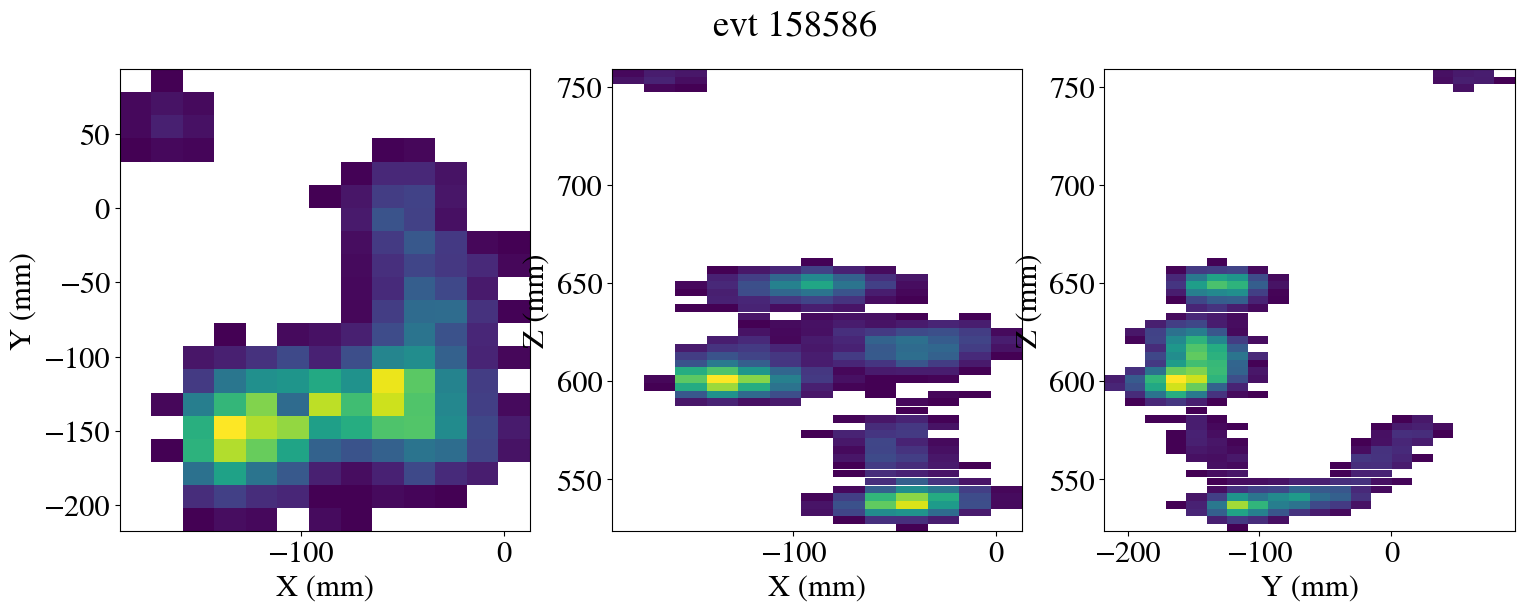

RUN NUMBER: 15589
TIMESTAMP: 456018
EVT: 158747


RUN NUMBER: 15589
TIMESTAMP: 456018
EVT: 158754


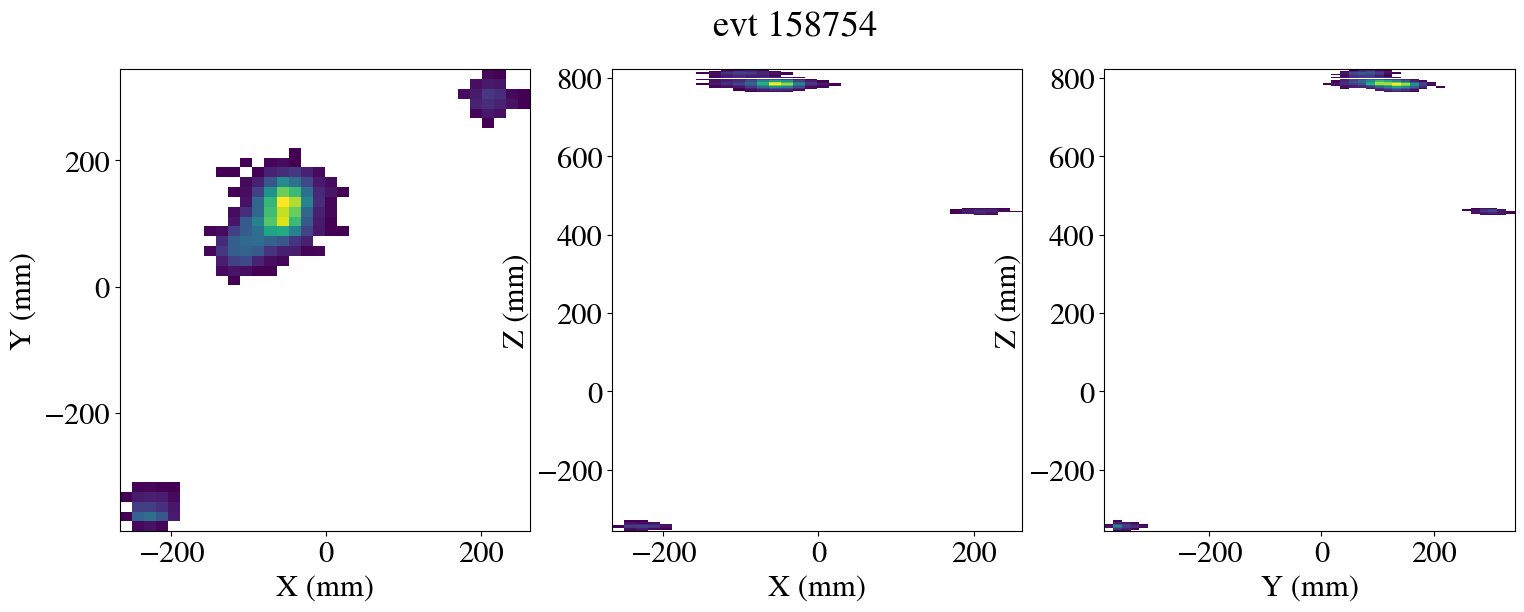

RUN NUMBER: 15589
TIMESTAMP: 456018
EVT: 158803


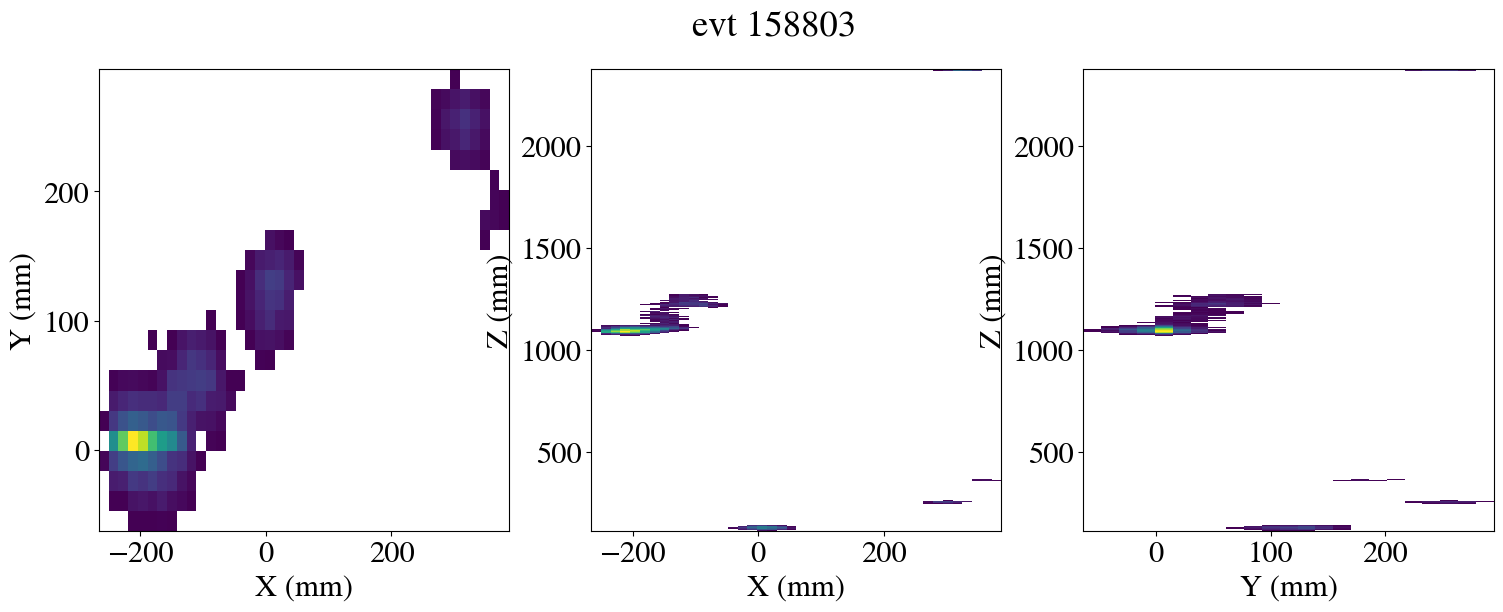

In [10]:
stopper = 10
for q, (RN, TS) in enumerate(zip(RUN_NUMBERS, TIMESTAMPS)):
    folder_path = f'/{data_path}/halmazan/NEXT/{DATA_PATH}/{RN}/thekla/{TS}/ldc1/'
    file_names = [f for f in os.listdir(folder_path) if f.endswith('.h5')]
    file_paths = [os.path.join(folder_path, f) for f in file_names]

    data = load_dst(file_paths[0], 'RECO', 'Events')

    
    for i, (evt, df) in enumerate(data.groupby('event')):
        print('='*20)
        print('='*20)
        print(f'RUN NUMBER: {RN}')
        print(f'TIMESTAMP: {TS}')
        print(f'EVT: {evt}')

        raw_plotter(df, evt)

        if i > stopper:
            break

# Plots

- Energy distribution and distribution of all variables

In [11]:
hdst.columns.values

array(['event', 'trackID', 'energy', 'length', 'numb_of_voxels',
       'numb_of_hits', 'numb_of_tracks', 'x_min', 'y_min', 'z_min',
       'r_min', 'x_max', 'y_max', 'z_max', 'r_max', 'x_ave', 'y_ave',
       'z_ave', 'r_ave', 'extreme1_x', 'extreme1_y', 'extreme1_z',
       'extreme2_x', 'extreme2_y', 'extreme2_z', 'blob1_x', 'blob1_y',
       'blob1_z', 'blob2_x', 'blob2_y', 'blob2_z', 'eblob1', 'eblob2',
       'ovlp_blob_energy', 'vox_size_x', 'vox_size_y', 'vox_size_z'],
      dtype=object)

In [12]:
top_vars  = ['length', 'numb_of_voxels',
             'numb_of_hits', 'numb_of_tracks']

top_labels = ['length (mm)', 'number of voxels',
              'number of hits', 'number of tracks']

geo_vars  = ['x_min', 'y_min', 'z_min',
             'r_min', 'x_max', 'y_max', 
             'z_max', 'r_max', 'x_ave',
             'y_ave', 'z_ave', 'r_ave']

geo_labels = ['(mm)'] * len(geo_vars)

blob_vars = ['extreme1_x', 'extreme1_y', 'extreme1_z',
             'extreme2_x', 'extreme2_y', 'extreme2_z', 
             'blob1_x', 'blob1_y', 'blob1_z', 
             'blob2_x', 'blob2_y', 'blob2_z', 
             'eblob1', 'eblob2',
             'ovlp_blob_energy']

blob_labels = ['mm'] * len(blob_vars[-3]) + ['Energy (MeV)'] * 3

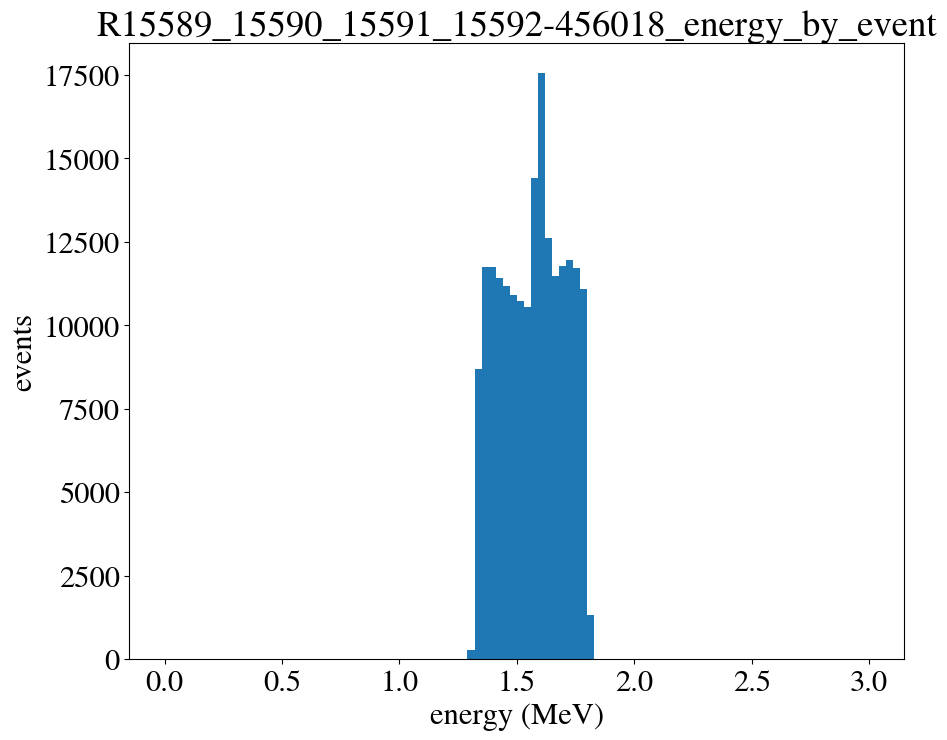

In [13]:
func.plot_hist_over_column(hdst
                           , 'event'
                           , 'energy'
                           , lambda x: x.sum()
                           , binning = 100
                           , range = (0, 3)
                           , log = False
                           , title = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_by_event'
                           , save = True
                           , save_dir = f'{folder_name}energy/')

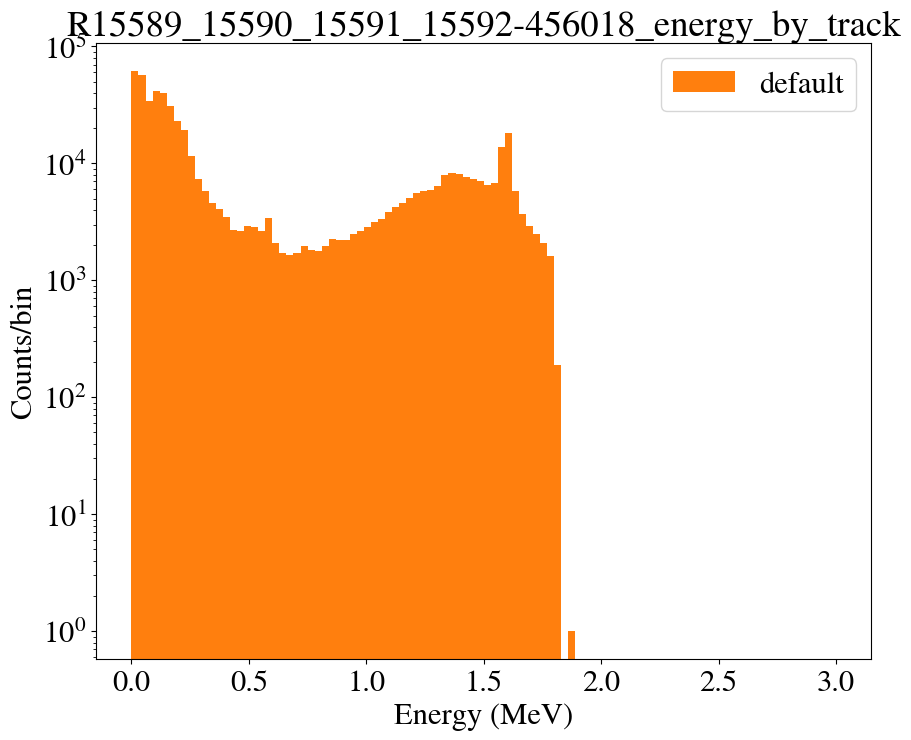

In [14]:
func.plot_hist( hdst
              , 'energy'
              , binning = 100
              , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_by_track'
              , x_label = 'Energy (MeV)'
              , range   = (0, 3)
              , log     = True
              , output  = True
              , save = True
              , save_dir = f'{folder_name}energy/')


func.plot_hist( hdst
              , 'energy'
              , binning = 100
              , title   = f'R{RUN_NUMBER}-{TIMESTAMP} - Energy by track'
              , x_label = 'Energy (MeV)'
              , range   = (0, 3)
              , log     = False
              , output  = True)

In [15]:
log_flag = True

# Topological output

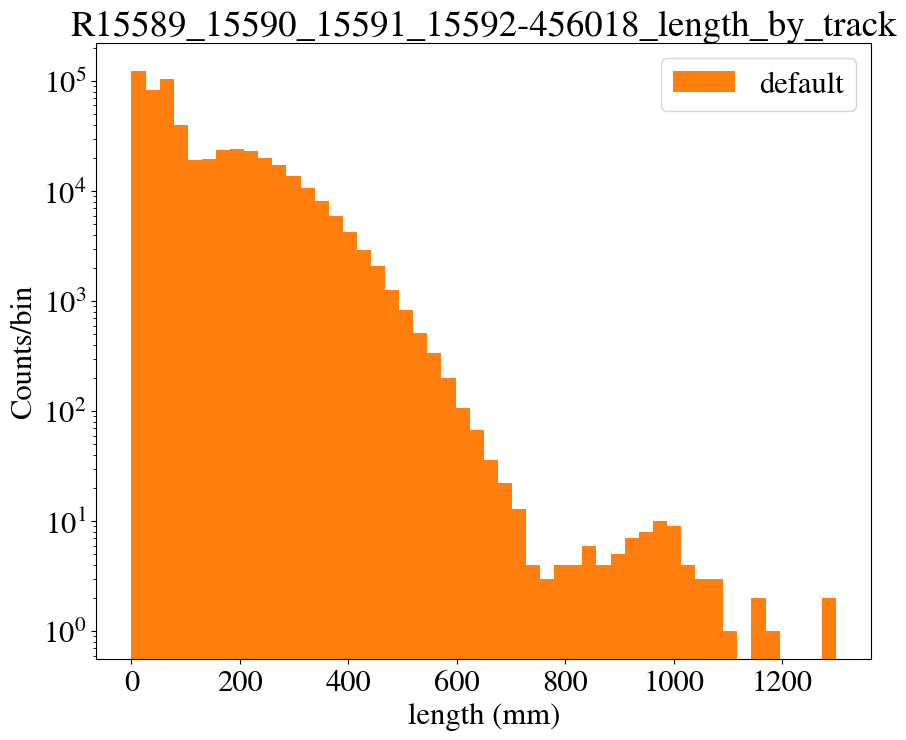

In [16]:
for vars, labels in zip(top_vars, top_labels):
    func.plot_hist( hdst
                  , vars
                  , binning  = 50
                  , title    = f'R{RUN_NUMBER}-{TIMESTAMP}_{vars}_by_track'
                  , x_label  = f'{labels}'
                  , outliers = (0, 99.99999)
                  , log      = log_flag
                  , output   = True
                  , save     = True
                  , save_dir = f'{folder_name}topology/')

# Geometric output

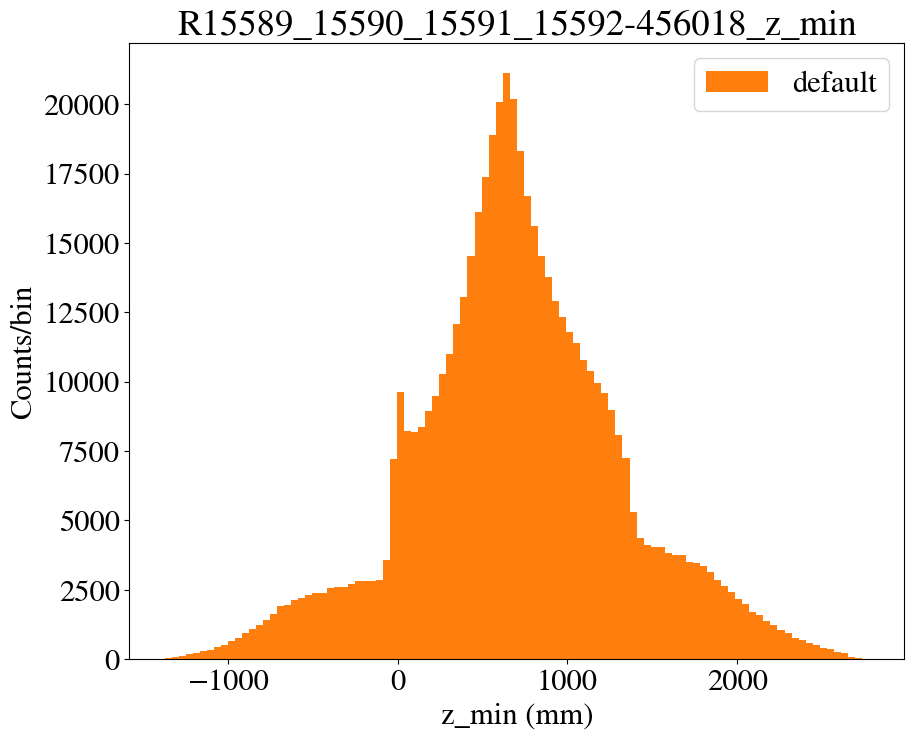

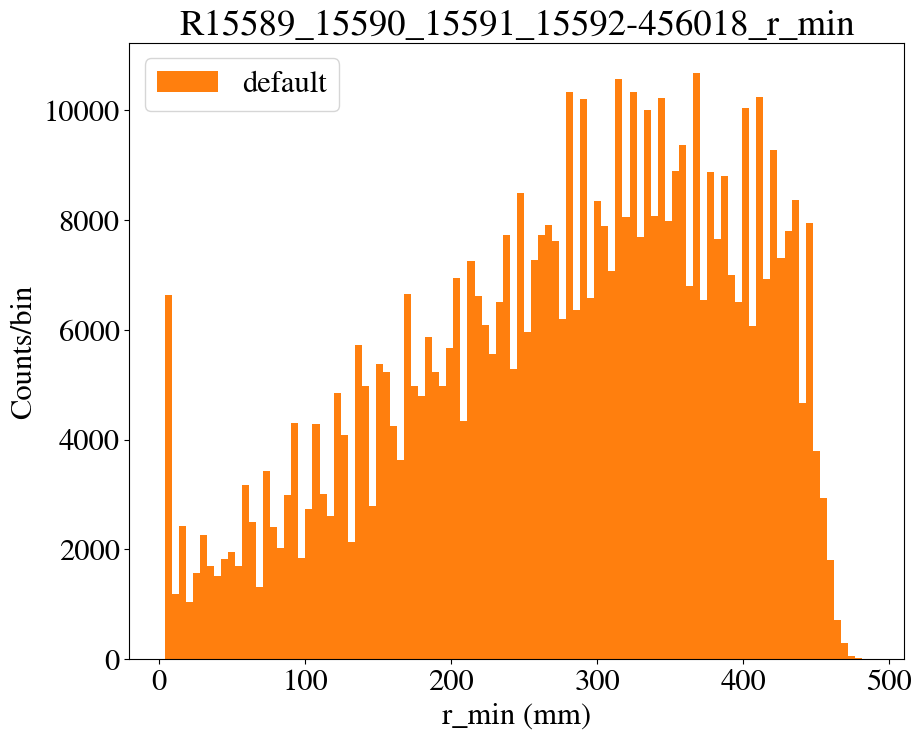

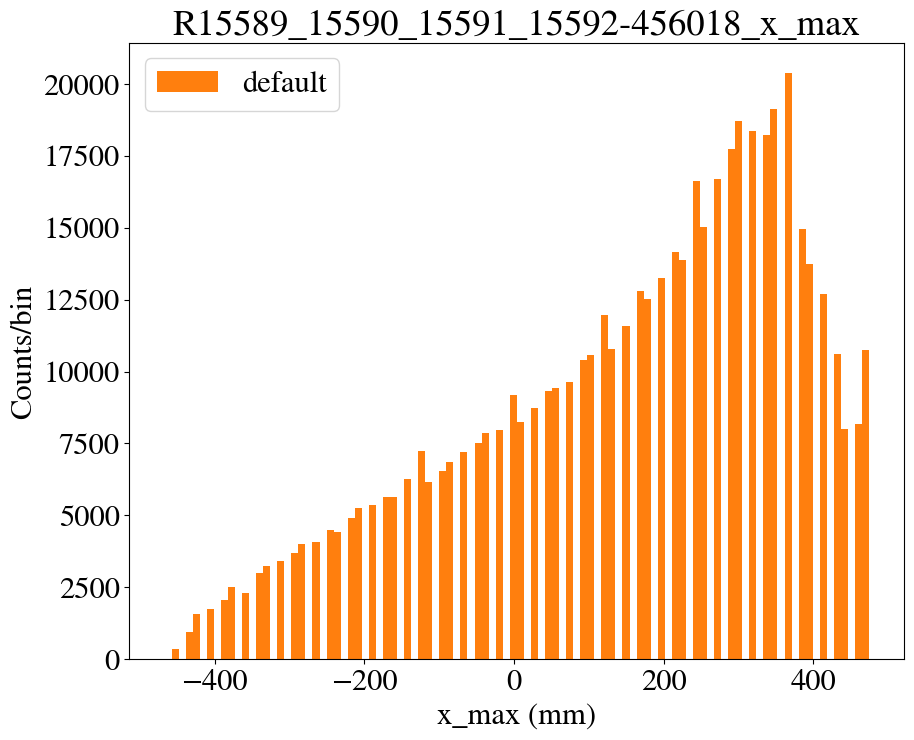

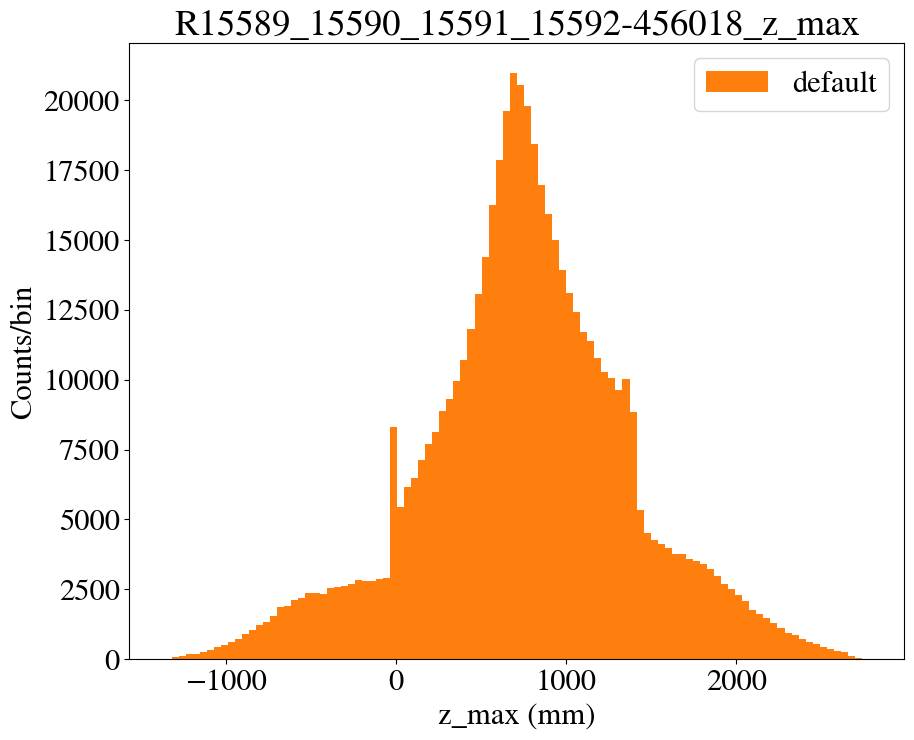

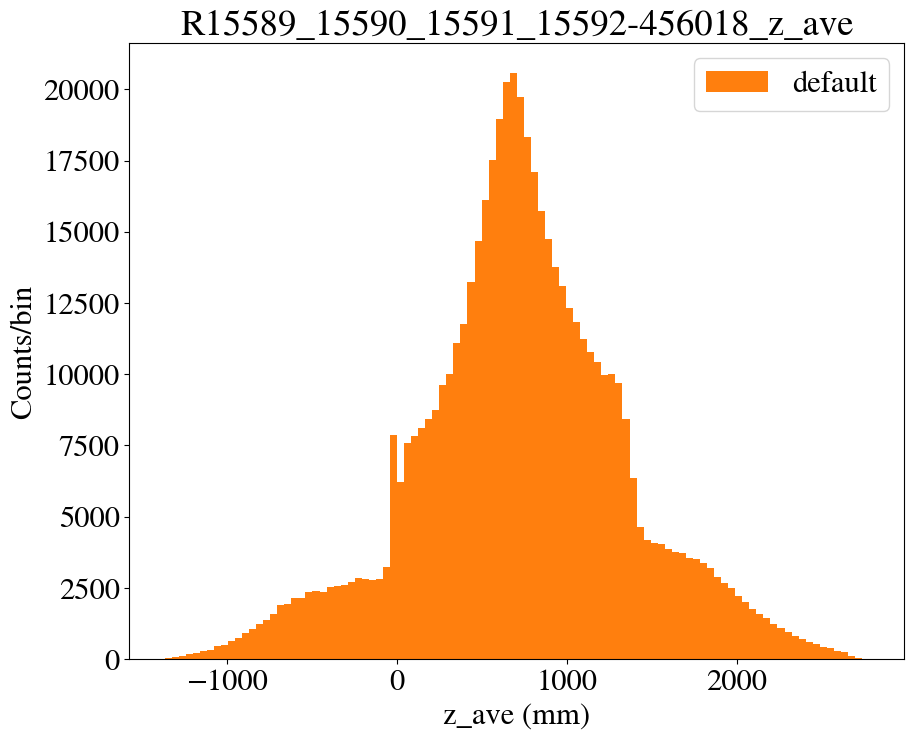

In [17]:
log_flag = False
for vars, labels in zip(geo_vars, geo_labels):
    func.plot_hist( hdst
                  , vars
                  , binning = 100
                  , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_{vars}'
                  , x_label = f'{vars} {labels}'
                  #, outliers   = (0, 99.99999)
                  , log     = log_flag
                  , output  = True
                  , save = True
                  , save_dir = f'{folder_name}geometry/')

# blob related output

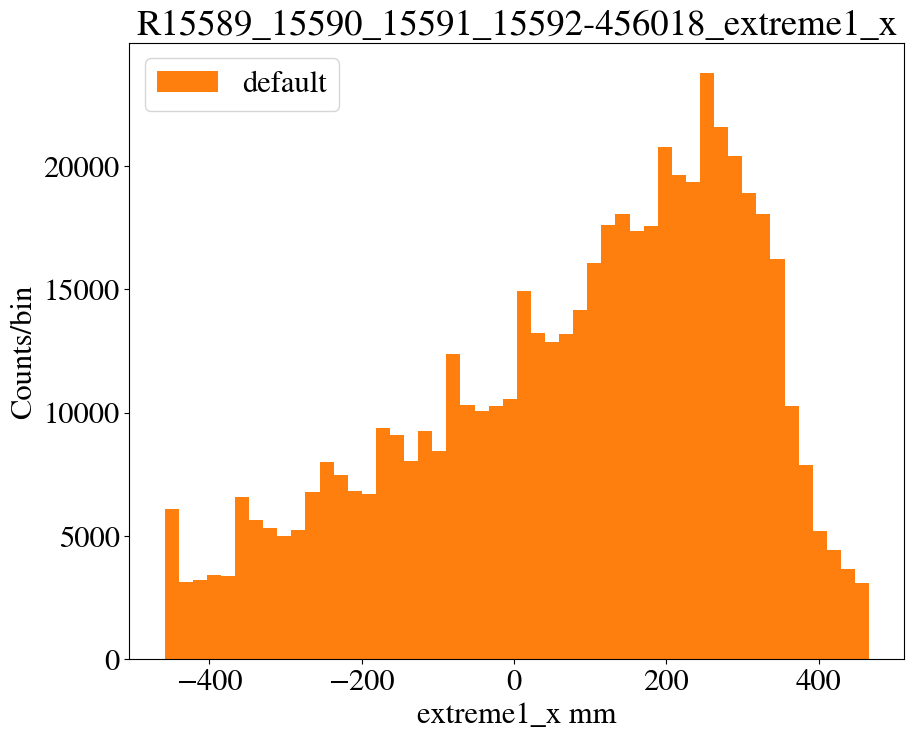

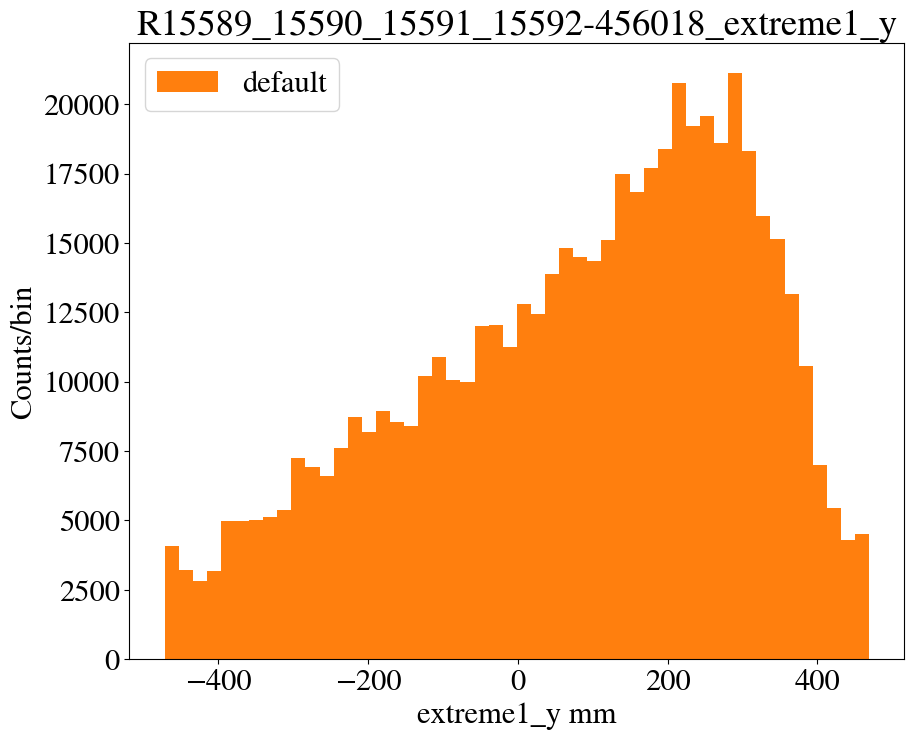

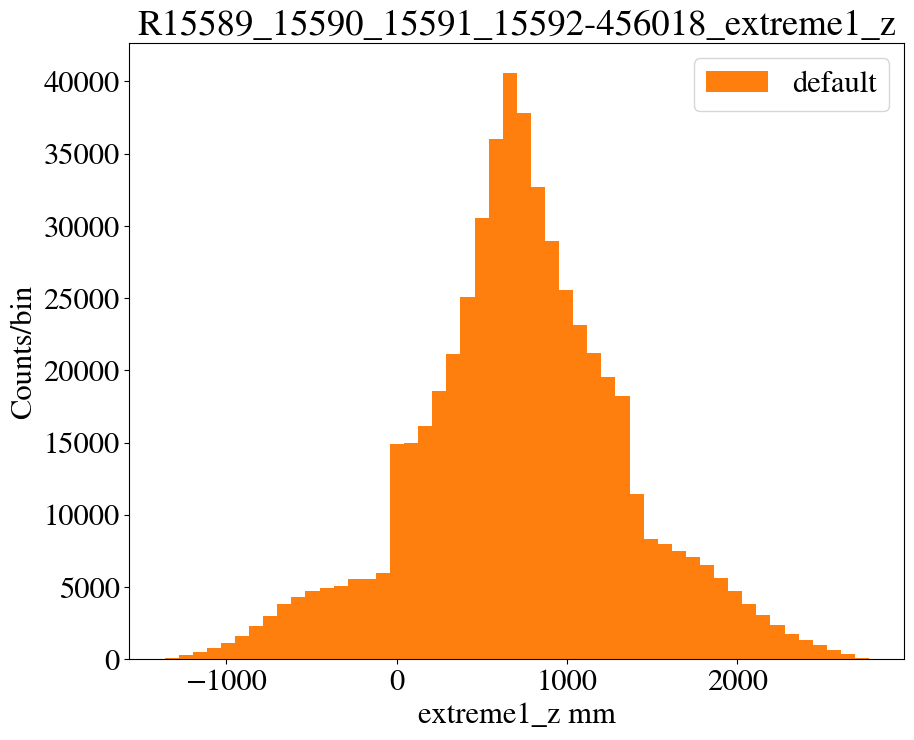

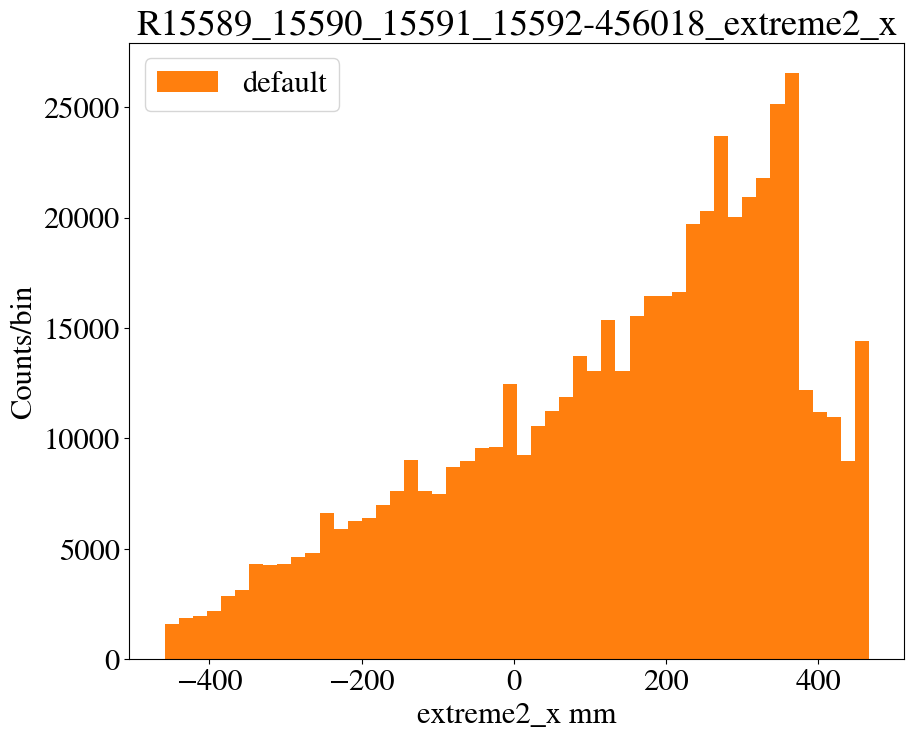

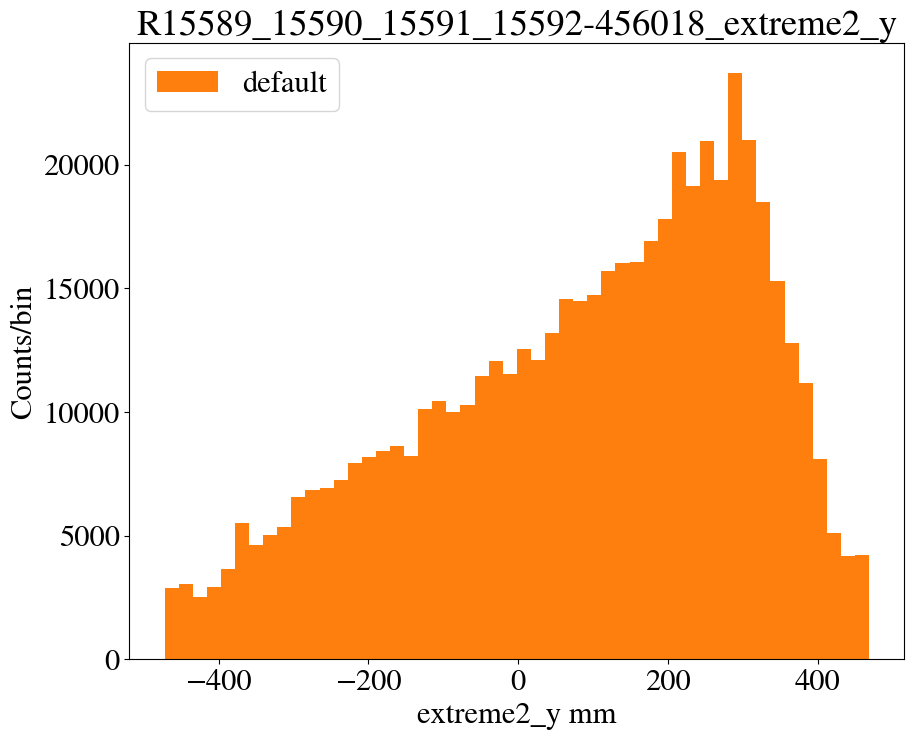

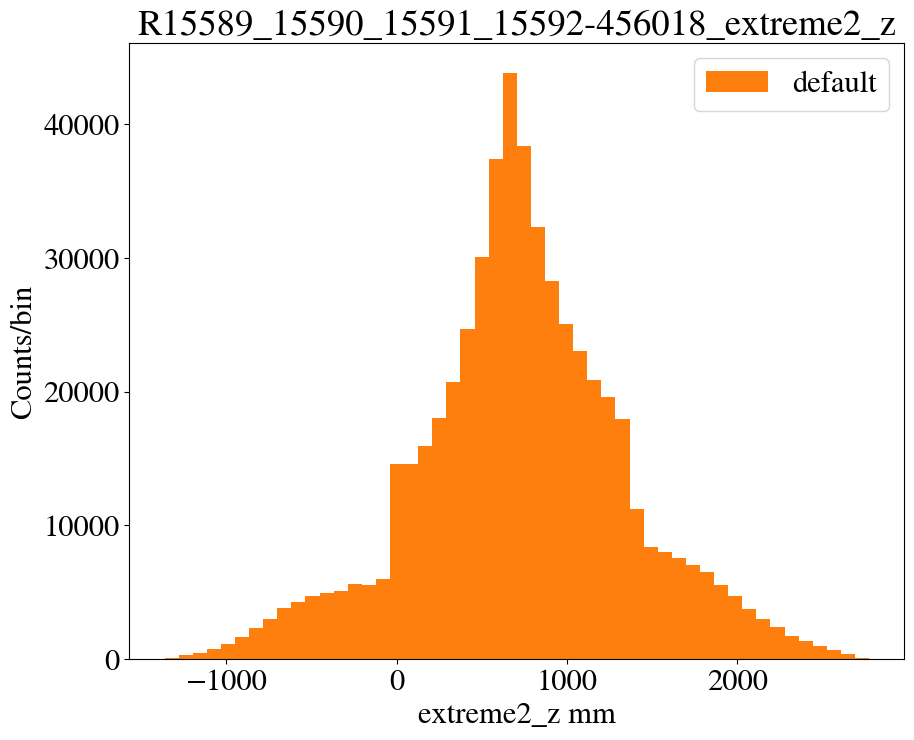

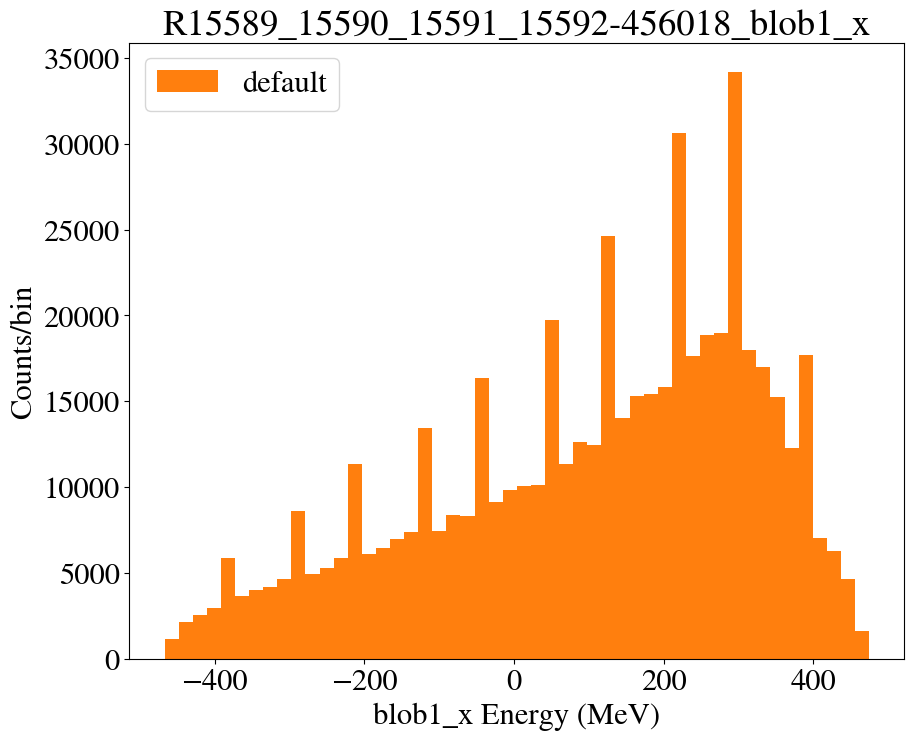

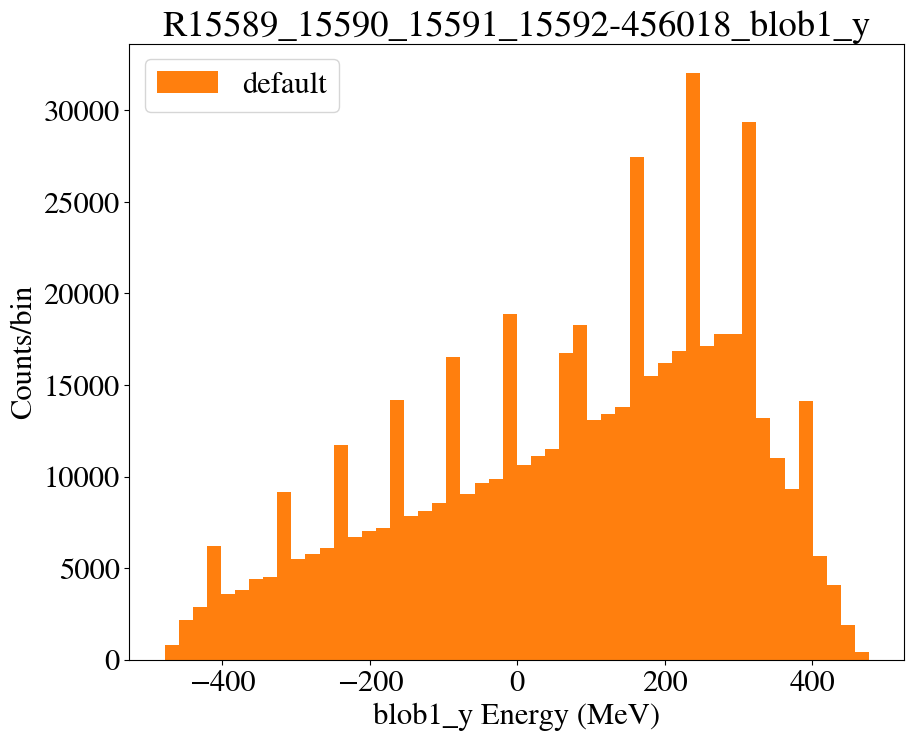

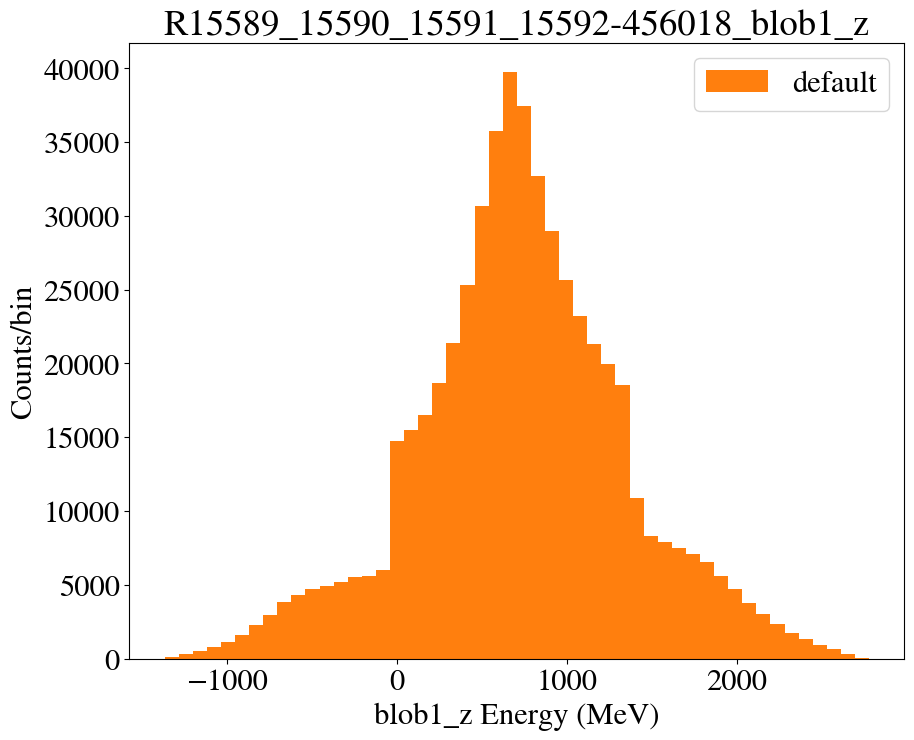

In [18]:
for vars, labels in zip(blob_vars, blob_labels):
    func.plot_hist( hdst
                  , vars
                  , binning = 50
                  , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_{vars}'
                  , x_label = f'{vars} {labels}'
                  #, outliers   = (0, 99.99999)
                  , log     = log_flag
                  , output  = True
                  , save = True
                  , save_dir = f'{folder_name}blob/')

# apply cuts and plot the same things

In [19]:
#######################################################################################
#########################   CUT PARAMETERS   #####################################
#######################################################################################
low_z = 20
upp_z  = 1195
r_lim = 450
low_e = 1.5
upp_e = 1.7

In [20]:
cut_hdst, efficiencies = func.apply_cuts(hdst, 
                                         lower_z = low_z, 
                                         upper_z = upp_z, 
                                         r_lim   = r_lim, 
                                         lower_e = low_e, 
                                         upper_e = upp_e)

display(efficiencies)

Cutting events around fiducial volume related to:
Z range between 20 and 1195
Radius range < 450
Fiducial track cut
Relative Cut efficiency:
Efficiency: 21.66 %
Absolute Cut efficiency:
Efficiency: 21.66 %
One track cut
Relative Cut efficiency:
Efficiency: 52.19 %
Absolute Cut efficiency:
Efficiency: 21.86 %

Blob overlap cut
Relative Cut efficiency:
Efficiency: 88.12 %
Absolute Cut efficiency:
Efficiency: 19.36 %
Energy cut
Relative Cut efficiency:
Efficiency: 59.67 %
Absolute Cut efficiency:
Efficiency: 29.73 %


Cut  Relative Efficiency  Relative Events  \
0            No cuts           100.000000           191184   
1      Fiducial Cuts            21.657670            41406   
2      One track cut            52.185674            21608   
3  Blob overlap cuts            88.115513            19040   
4        Energy cuts            59.674370            11362   

   Single Cut Efficiency  
0             100.000000  
1              21.657670  
2              21.861662  
3              19.362499  
4              29.727906

In [21]:
# SAVE THE DATAFRAME
cut_hdst.to_hdf(f'{folder_name}{RUN_NUMBER}_{TIMESTAMP}.h5', key = 'Tracking/Tracks')

In [22]:
# save the efficiency table
efficiencies.to_csv(f'{folder_name}efficiency.csv')

In [23]:
print(f'{folder_name}efficiency.csv')
display(pd.read_csv(f'{folder_name}efficiency.csv'))

/scratch/halmazan/NEXT/testing/notebooks/15589_15590_15591_15592_456018_thekla/efficiency.csv


Unnamed: 0                Cut  Relative Efficiency  Relative Events  \
0           0            No cuts           100.000000           191184   
1           1      Fiducial Cuts            21.657670            41406   
2           2      One track cut            52.185674            21608   
3           3  Blob overlap cuts            88.115513            19040   
4           4        Energy cuts            59.674370            11362   

   Single Cut Efficiency  
0             100.000000  
1              21.657670  
2              21.861662  
3              19.362499  
4              29.727906

In [24]:
# check a different one quickly
print(folder_name)
folder_check = folder_name
print(f'{folder_check}efficiency.csv')
display(pd.read_csv(f'{folder_check}efficiency.csv'))

/scratch/halmazan/NEXT/testing/notebooks/15589_15590_15591_15592_456018_thekla/
/scratch/halmazan/NEXT/testing/notebooks/15589_15590_15591_15592_456018_thekla/efficiency.csv


Unnamed: 0                Cut  Relative Efficiency  Relative Events  \
0           0            No cuts           100.000000           191184   
1           1      Fiducial Cuts            21.657670            41406   
2           2      One track cut            52.185674            21608   
3           3  Blob overlap cuts            88.115513            19040   
4           4        Energy cuts            59.674370            11362   

   Single Cut Efficiency  
0             100.000000  
1              21.657670  
2              21.861662  
3              19.362499  
4              29.727906

# And plot again

disable the `log_flag` for low statistics

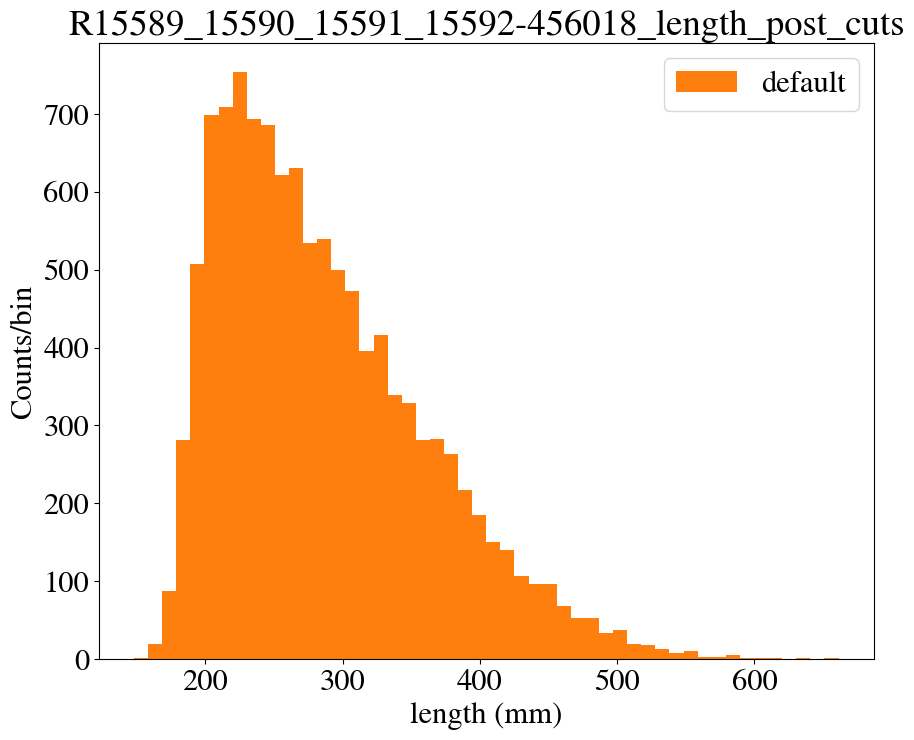

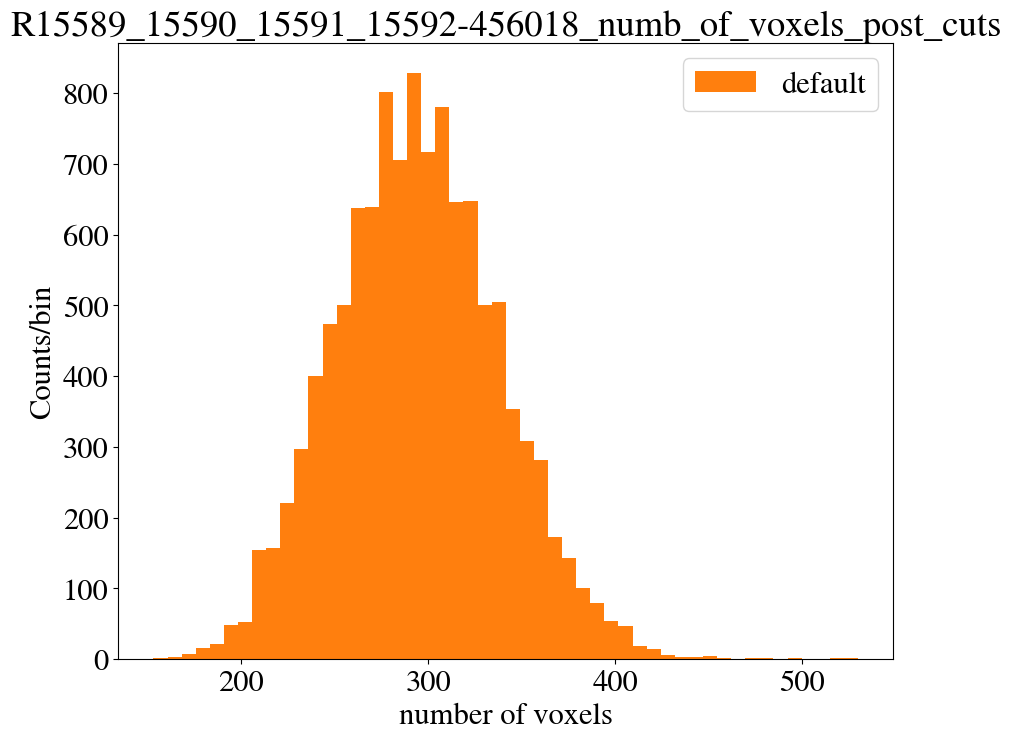

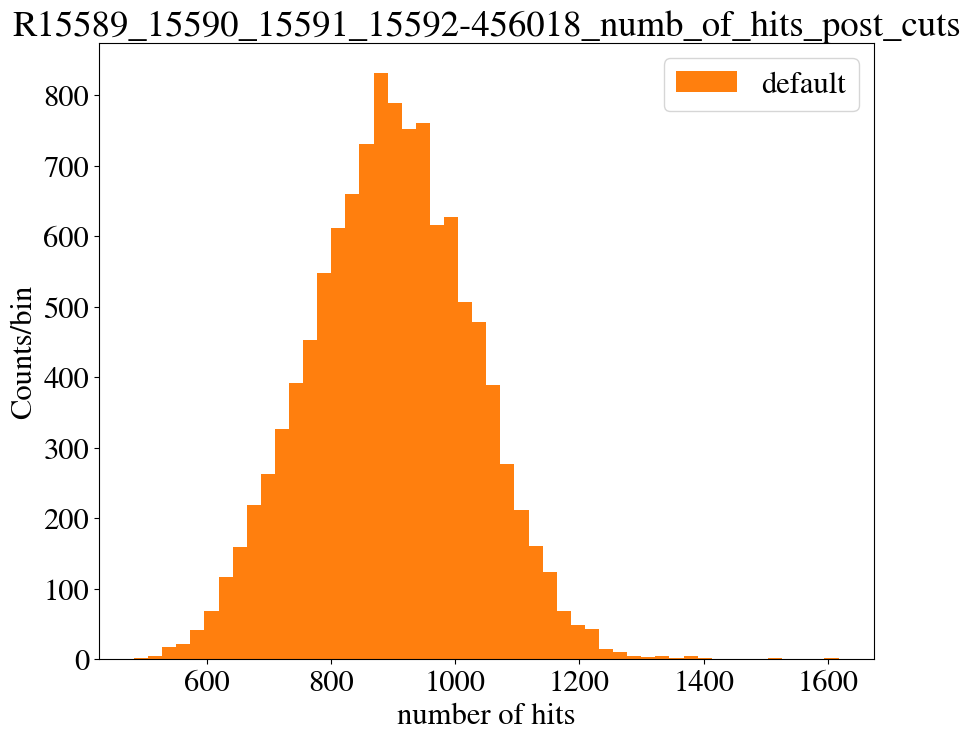

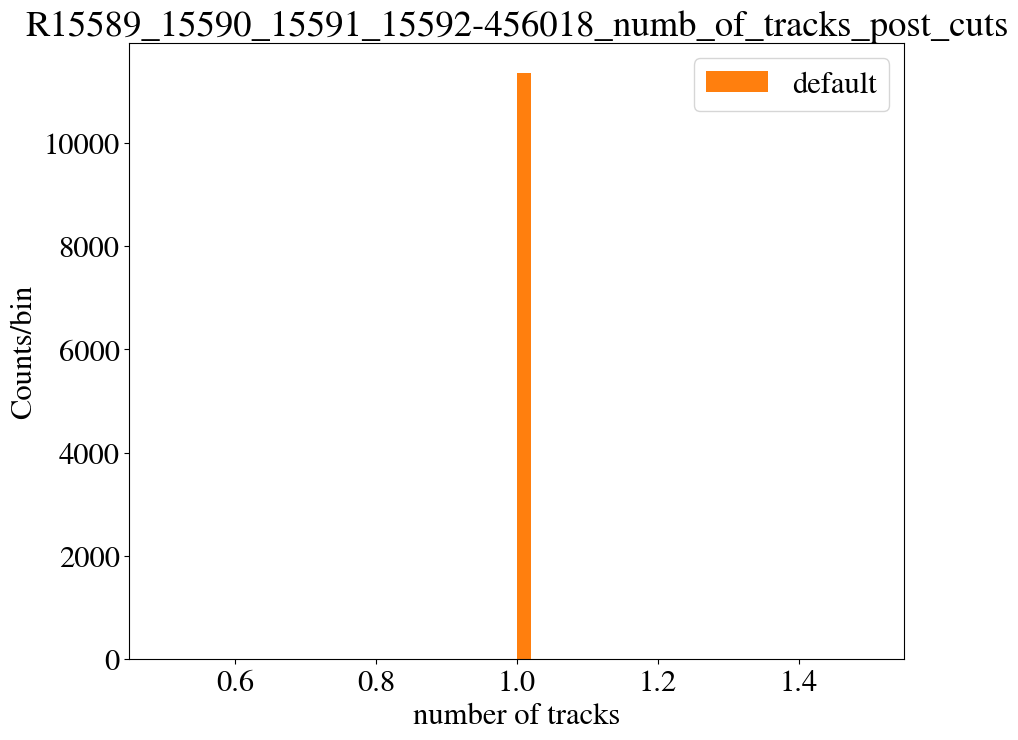

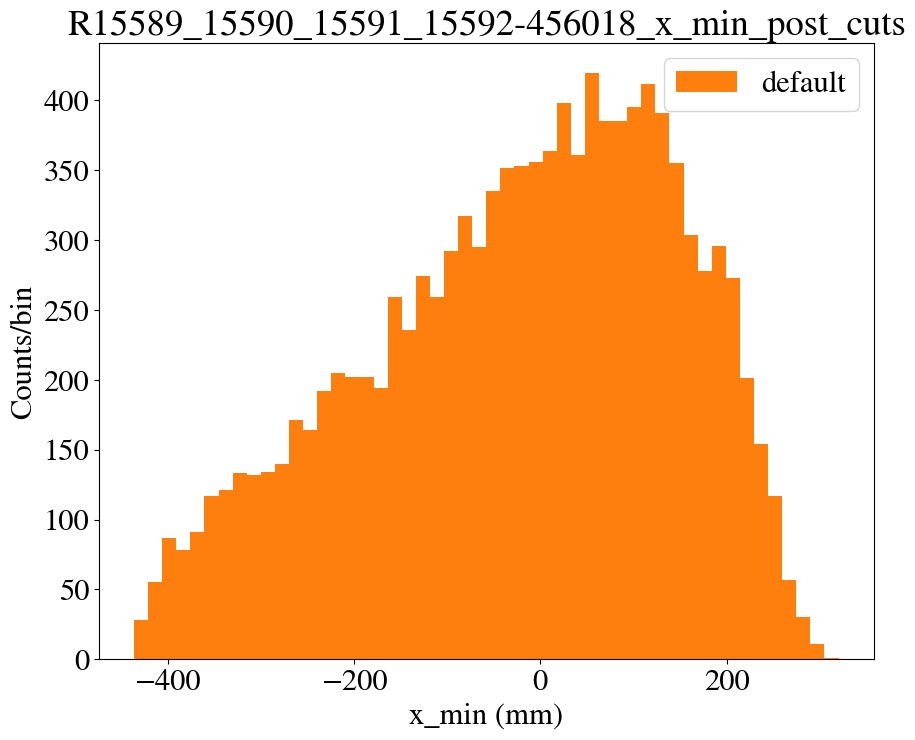

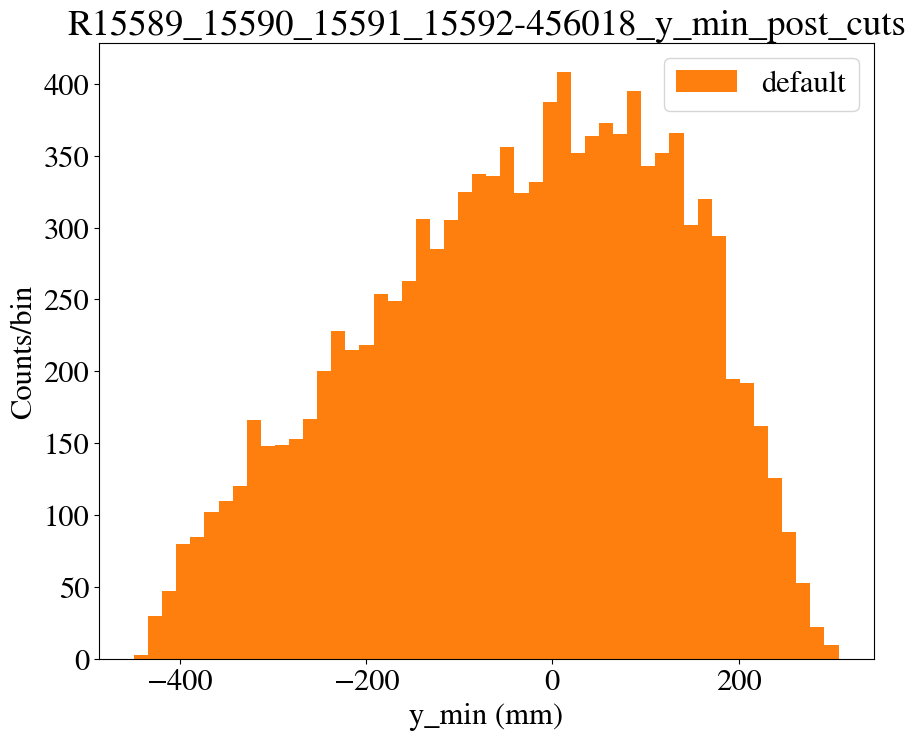

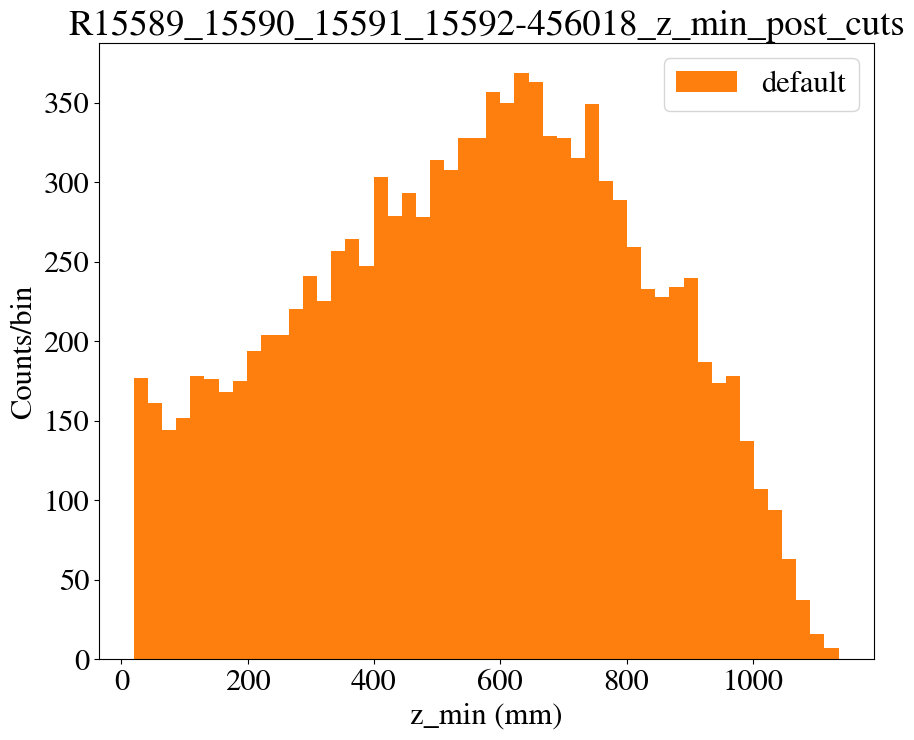

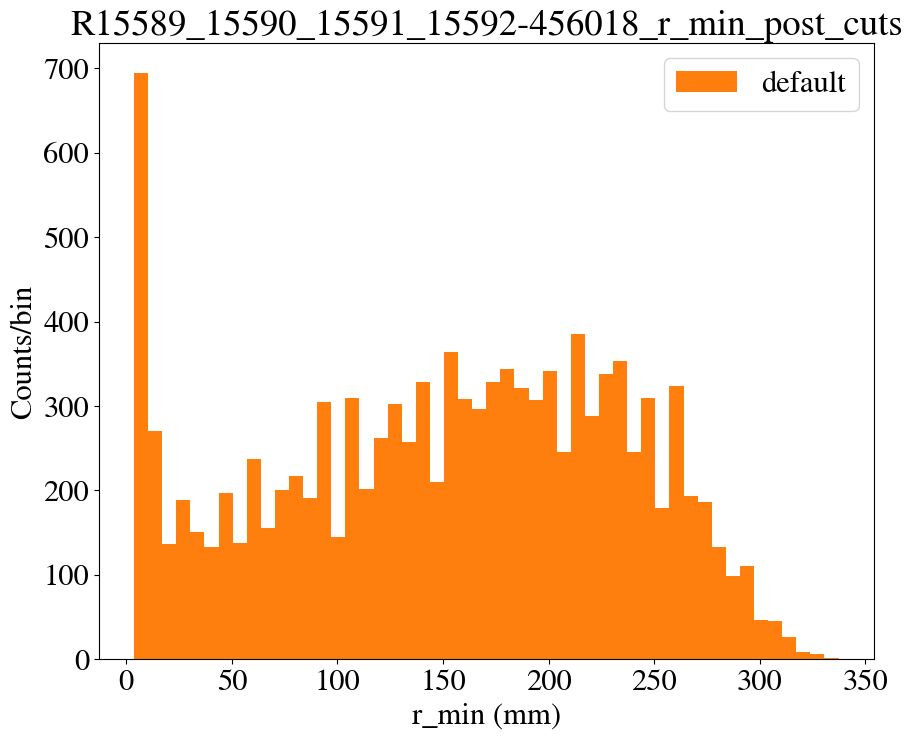

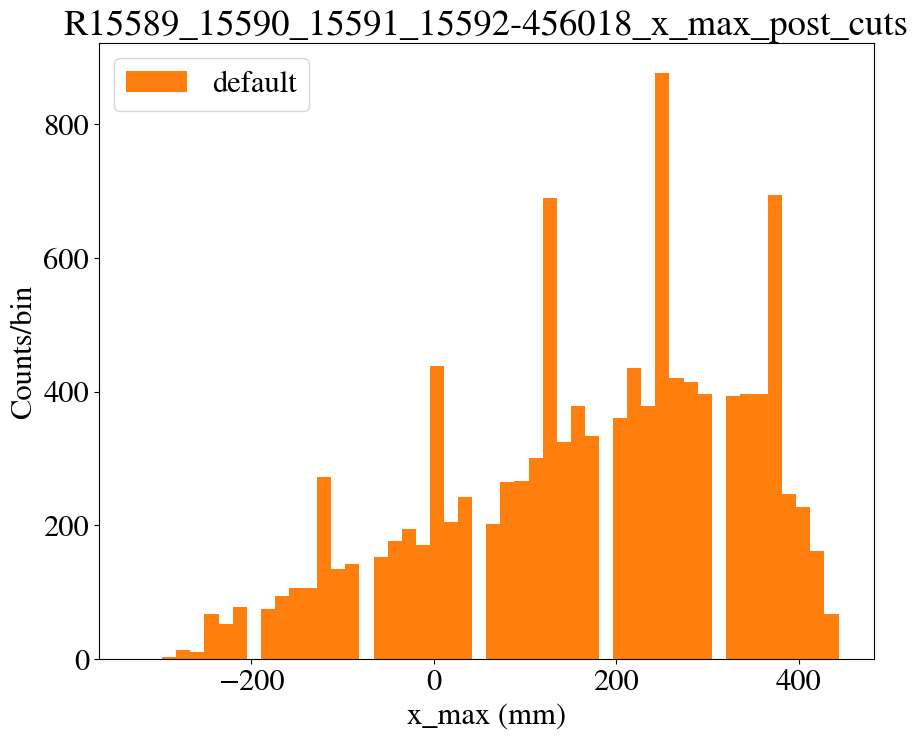

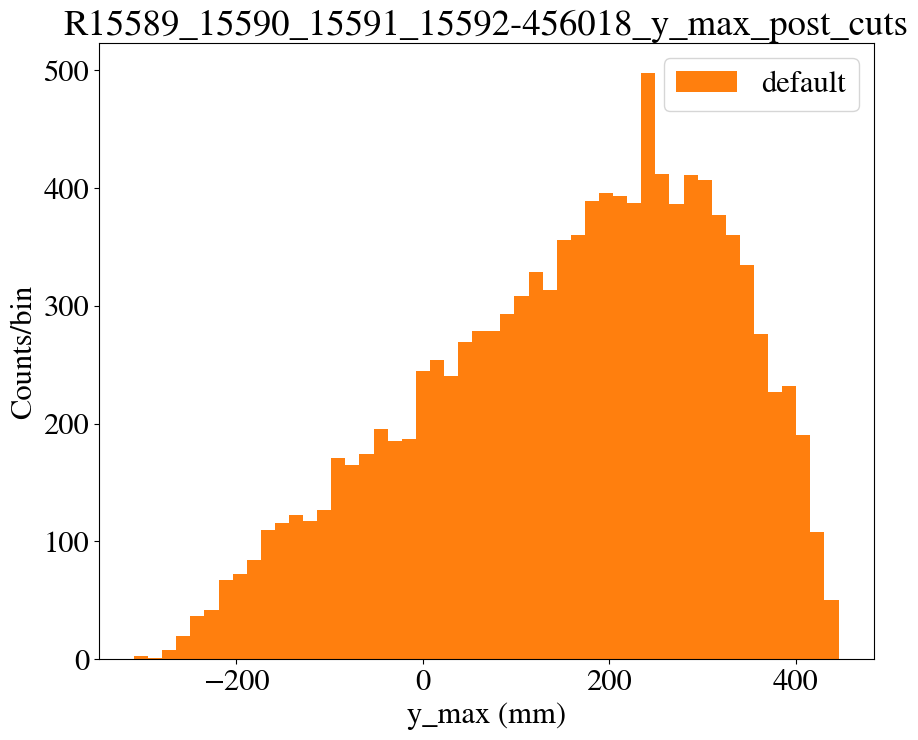

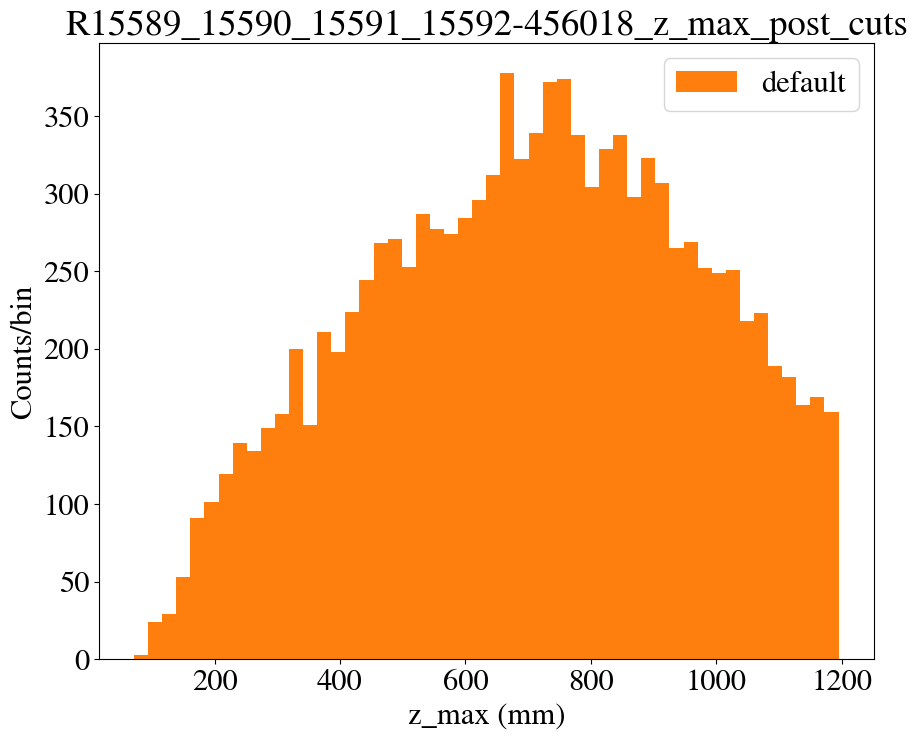

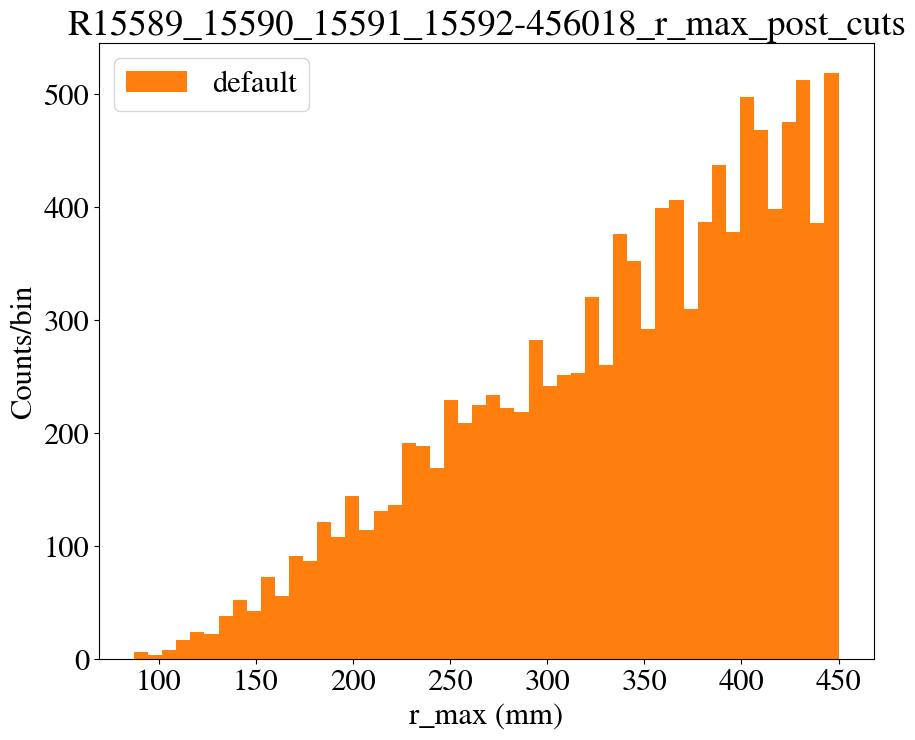

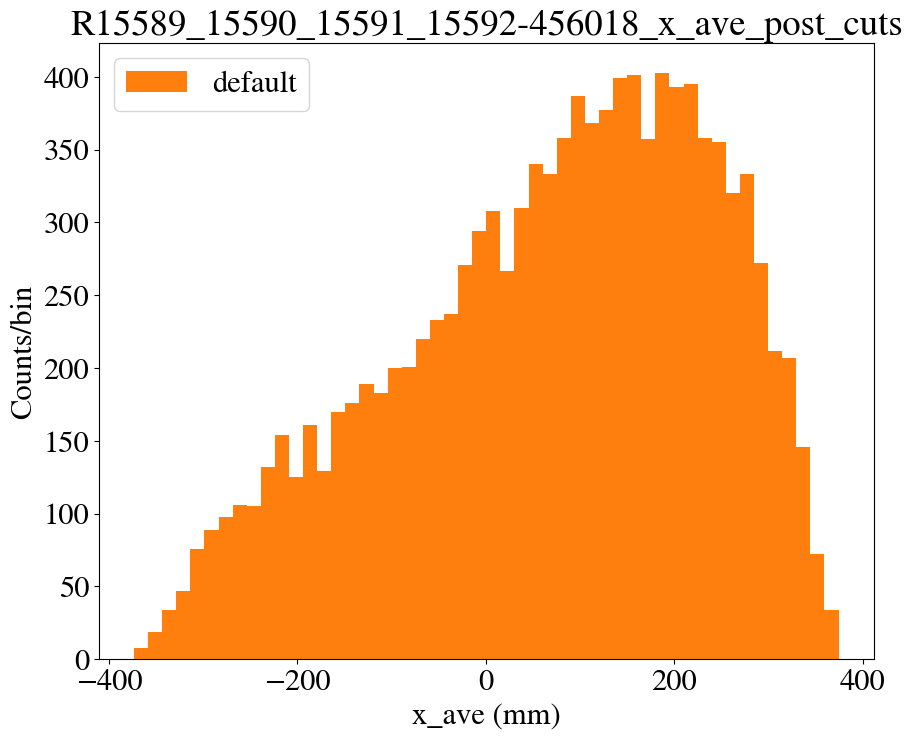

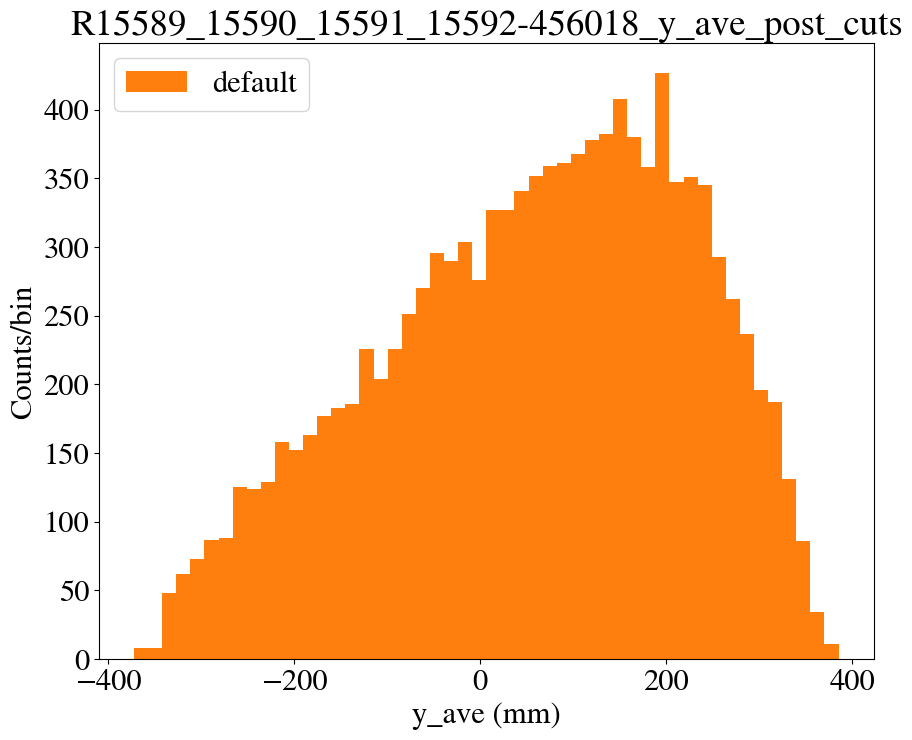

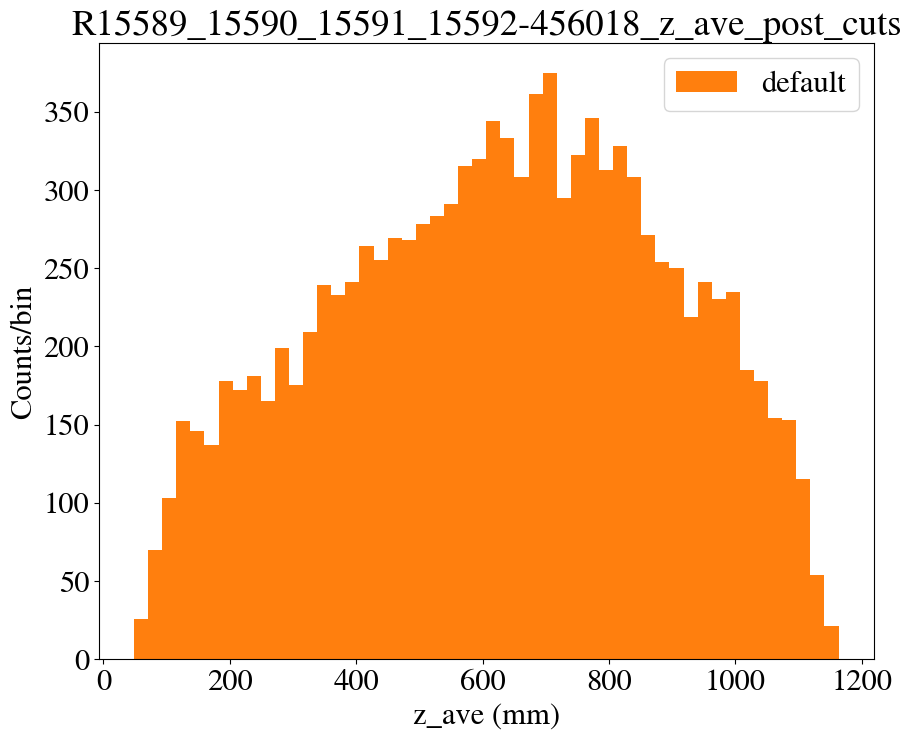

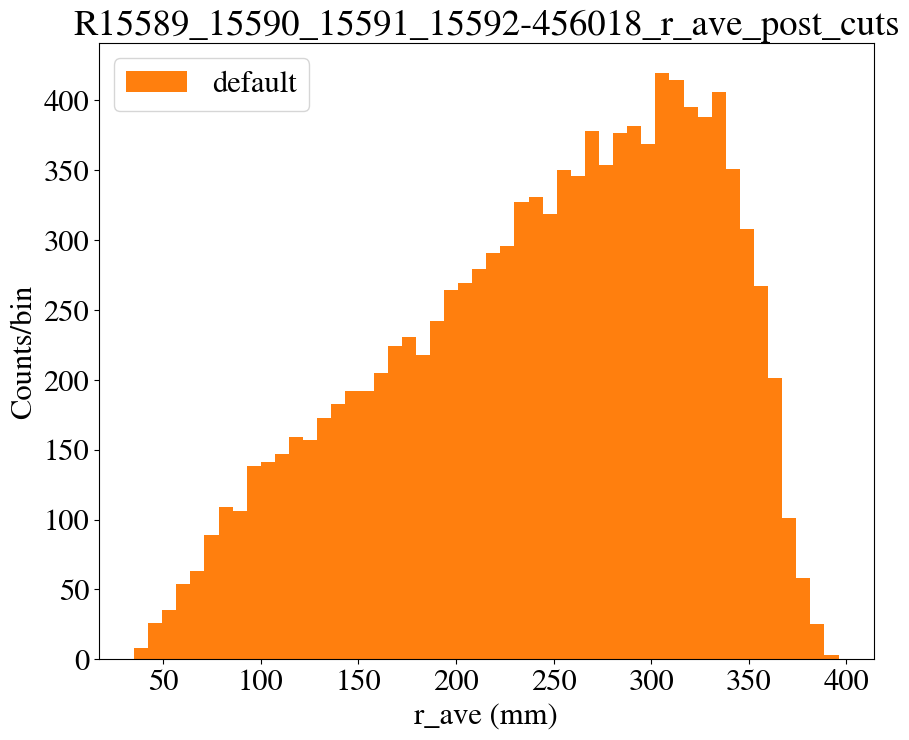

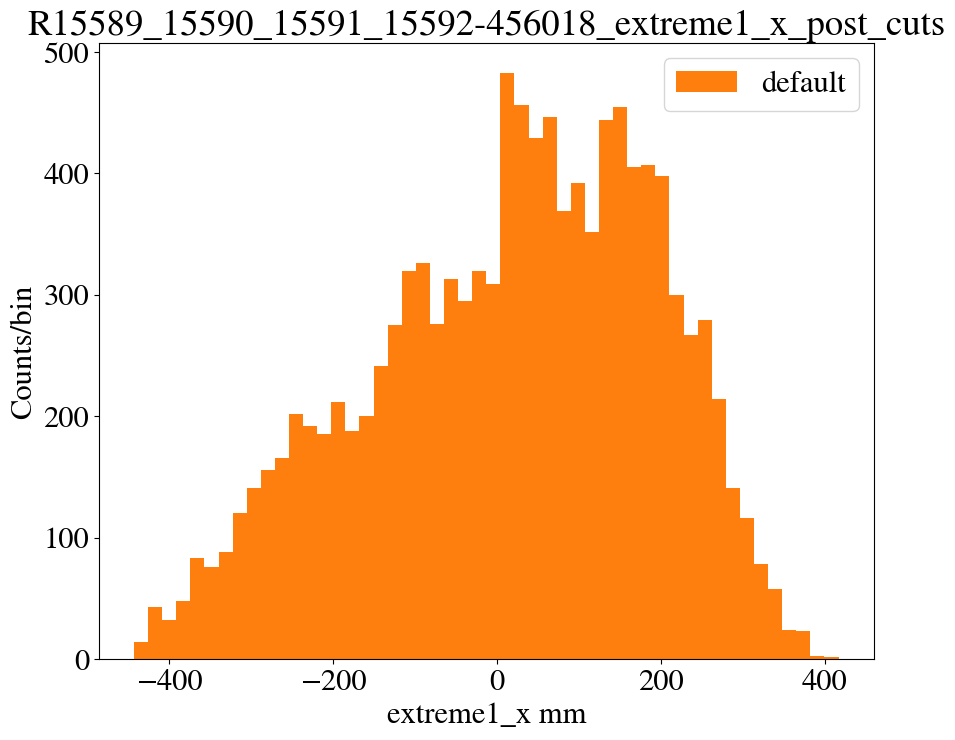

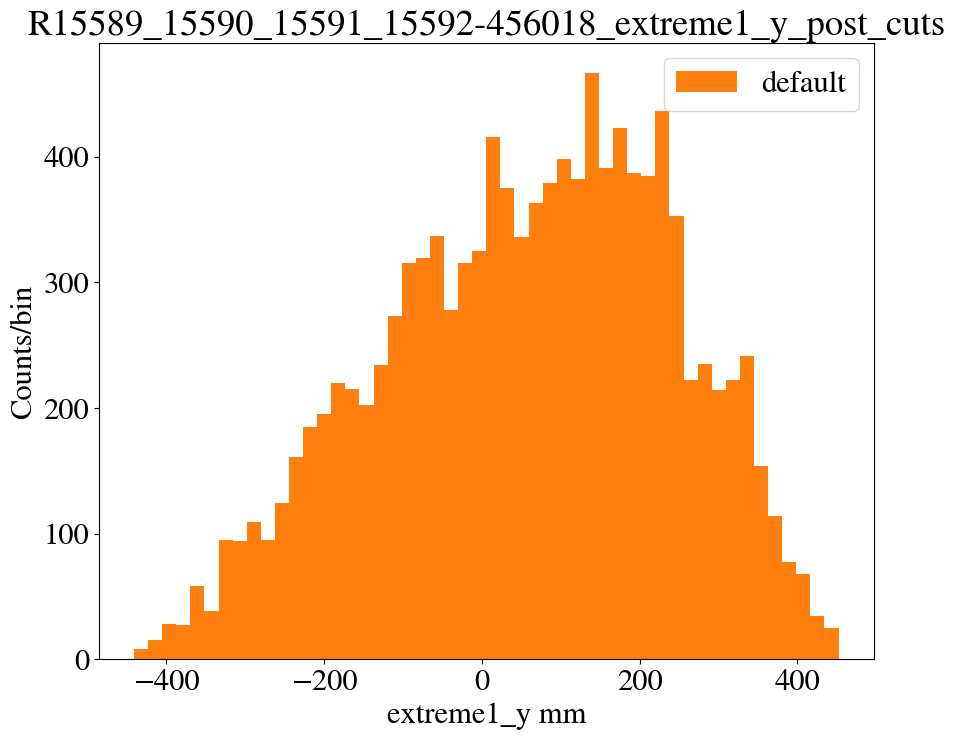

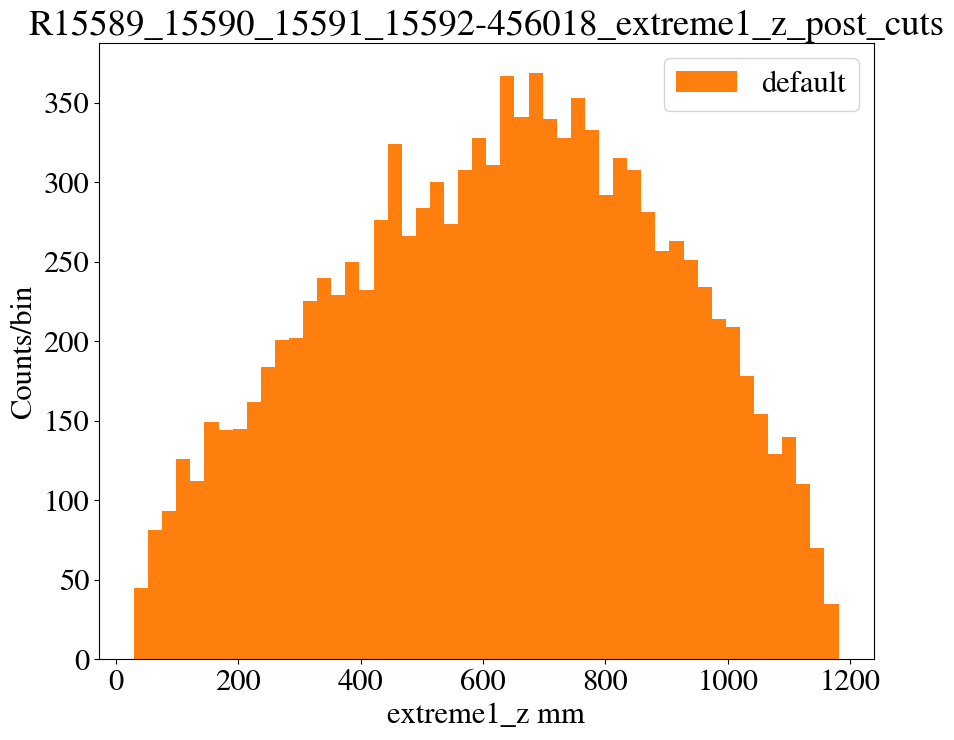

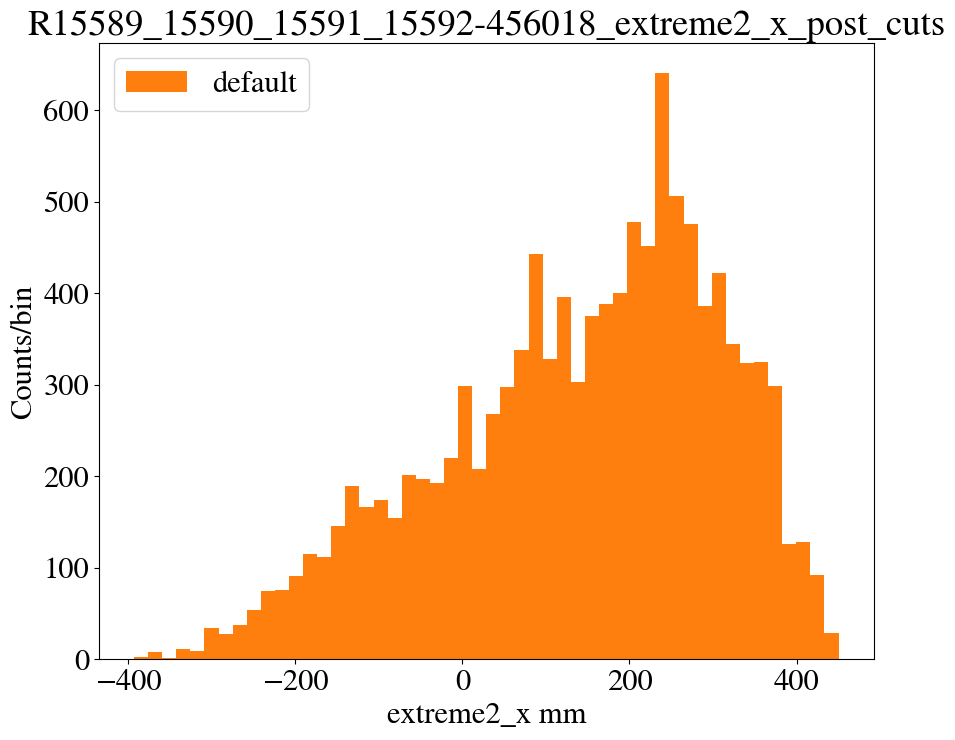

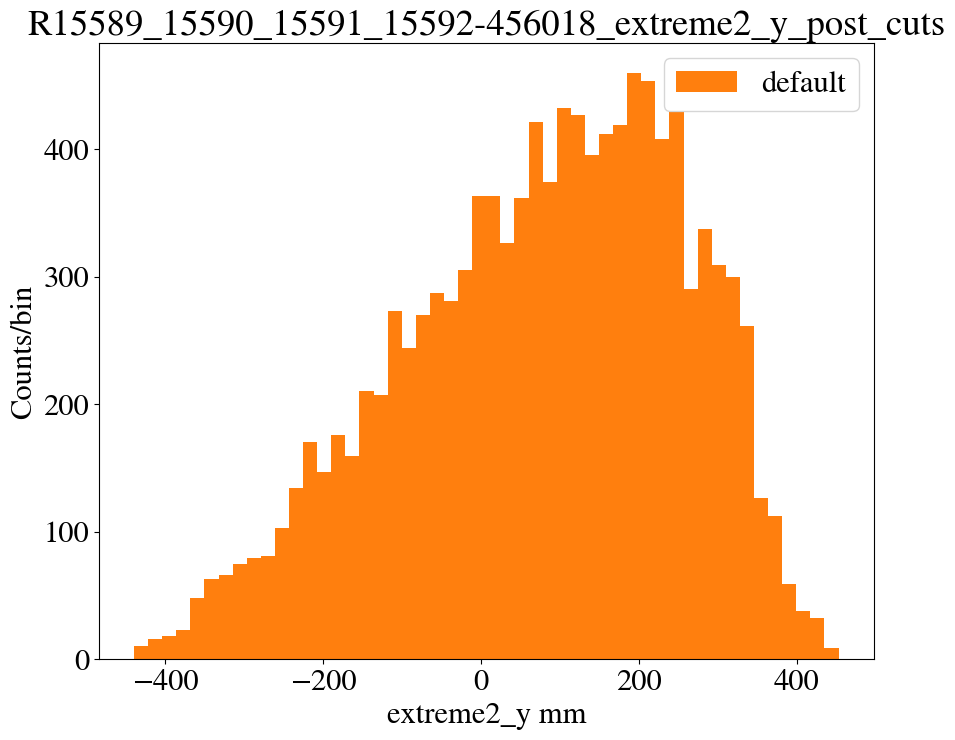

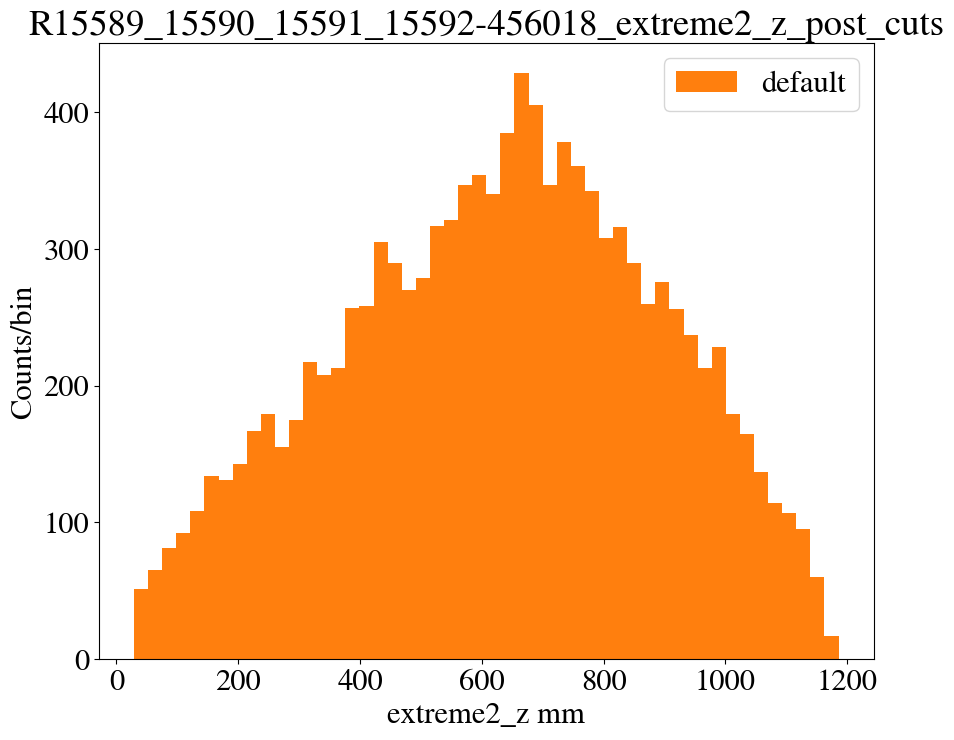

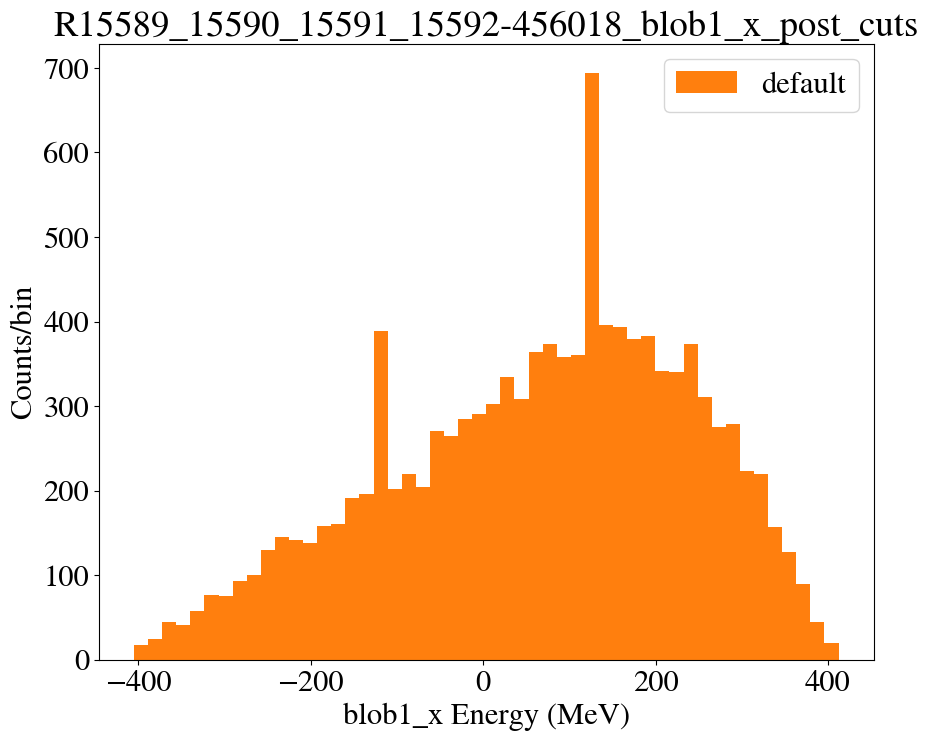

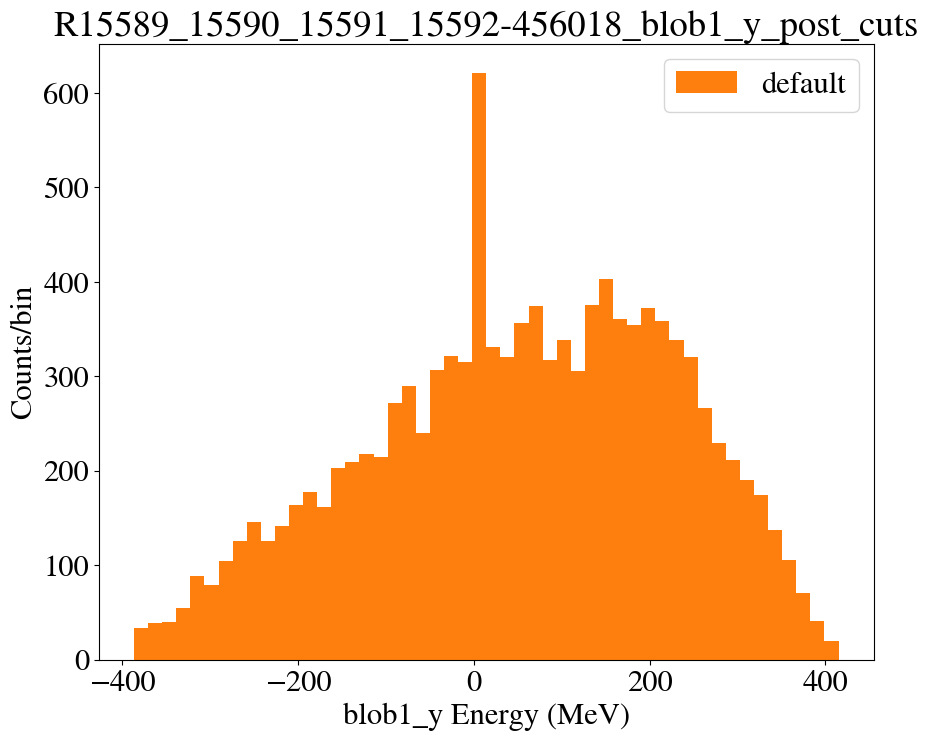

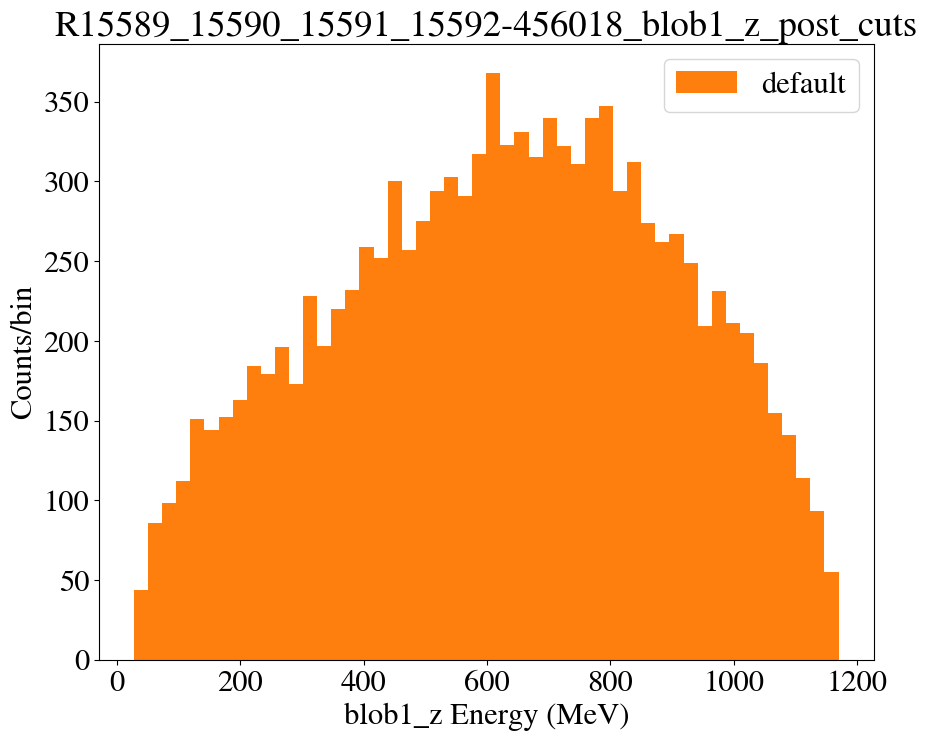

In [25]:
log_flag = False
#############################################################
##################### TOPOLOGICAL ###########################
#############################################################

for vars, labels in zip(top_vars, top_labels):
    func.plot_hist( cut_hdst
                  , vars
                  , binning  = 50
                  , title    = f'R{RUN_NUMBER}-{TIMESTAMP}_{vars}_post_cuts'
                  , x_label  = f'{labels}'
                  , outliers = (0, 99.99999)
                  , log      = log_flag
                  , output   = True
                  , save     = True
                  , save_dir = f'{folder_name}topology/')
    

#############################################################
###################### GEOMETRIC ############################
#############################################################

for vars, labels in zip(geo_vars, geo_labels):
    func.plot_hist( cut_hdst
                  , vars
                  , binning = 50
                  , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_{vars}_post_cuts'
                  , x_label = f'{vars} {labels}'
                  #, outliers   = (0, 99.99999)
                  , log     = log_flag
                  , output  = True
                  , save = True
                  , save_dir = f'{folder_name}geometry/')
    
for vars, labels in zip(blob_vars, blob_labels):
    func.plot_hist( cut_hdst
                  , vars
                  , binning = 50
                  , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_{vars}_post_cuts'
                  , x_label = f'{vars} {labels}'
                  #, outliers   = (0, 99.99999)
                  , log     = log_flag
                  , output  = True
                  , save = True
                  , save_dir = f'{folder_name}blob/')

# look at satellites here

Maximal number of tracks: 0        3
1        3
2        3
3        2
4        2
        ..
78180    4
78181    4
78182    4
78183    4
78184    1
Name: numb_of_tracks, Length: 548511, dtype: int64


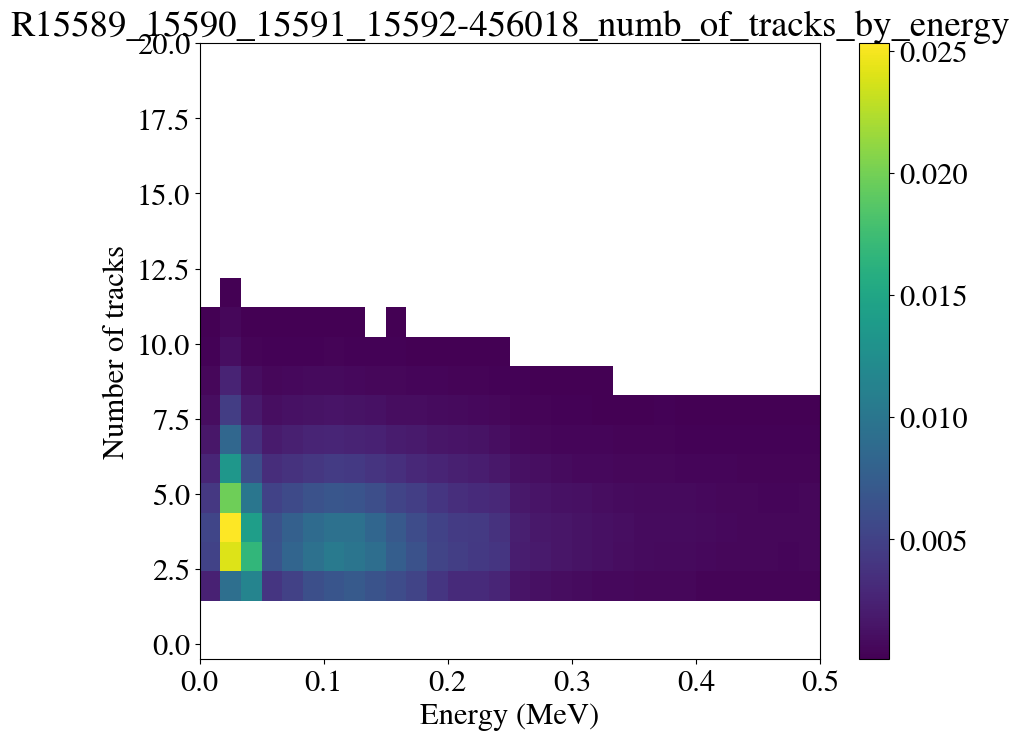

In [26]:
# useful to normalize histograms
def get_weights(data, norm):
    if norm:
        return np.repeat(1.0/len(data), len(data))
    else:
        return np.repeat(1.0, len(data))

track_energy = hdst.energy
track_no = hdst.numb_of_tracks
# normalise
print(f'Maximal number of tracks: {track_no}')
weights = get_weights(track_energy, True)
#plt.hist2d(track_energy, track_no, bins=(50, 20), cmin=0.001)
#plt.hist2d(track_energy, track_no, weights = weights, bins=(30, 21), cmin=0.0001)
plt.hist2d(track_energy, track_no, weights = weights, bins=(30, 21), cmin=0.0001, range = ((0,0.5),(-0.5,20)))
title_trck_num = f'R{RUN_NUMBER}-{TIMESTAMP}_numb_of_tracks_by_energy'
plt.title(f'{title_trck_num}')
plt.colorbar()
plt.xlabel('Energy (MeV)')
plt.ylabel('Number of tracks')
plt.savefig(f'{folder_name}energy/{title_trck_num}.png')
plt.show()

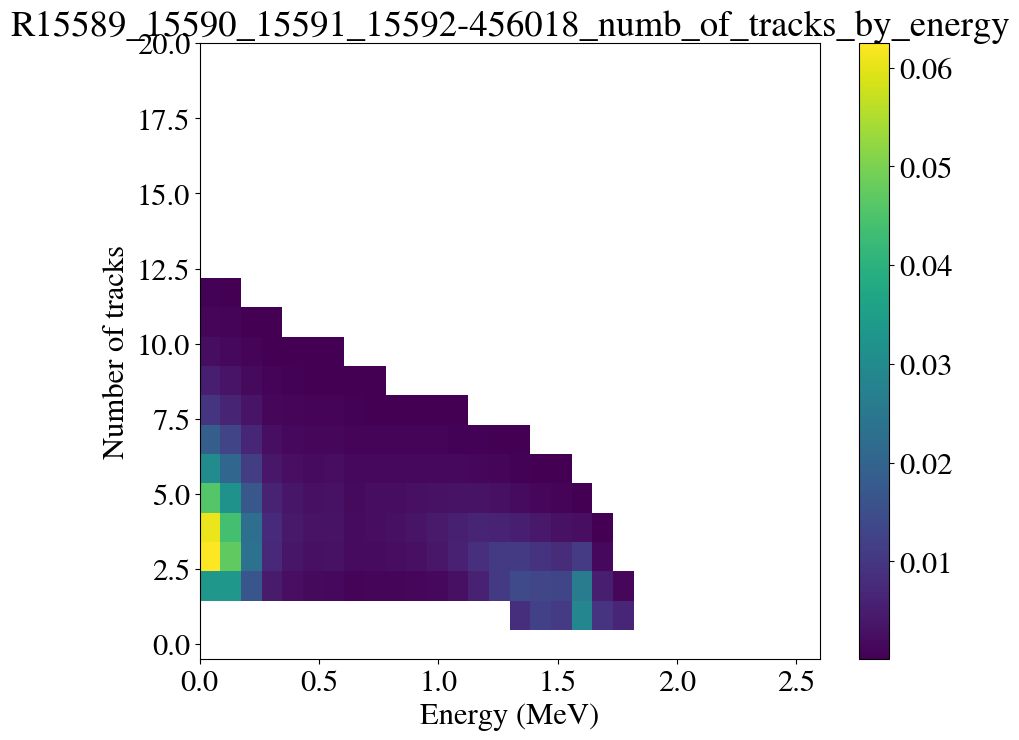

In [27]:
plt.hist2d(track_energy, track_no, weights = weights, bins=(30, 21), cmin=0.0001, range = ((0,2.6),(-0.5,20)))
title_trck_num = f'R{RUN_NUMBER}-{TIMESTAMP}_numb_of_tracks_by_energy'
plt.title(f'{title_trck_num}')
plt.colorbar()
plt.xlabel('Energy (MeV)')
plt.ylabel('Number of tracks')
plt.show()

# And blob 1 blob 2 distributions

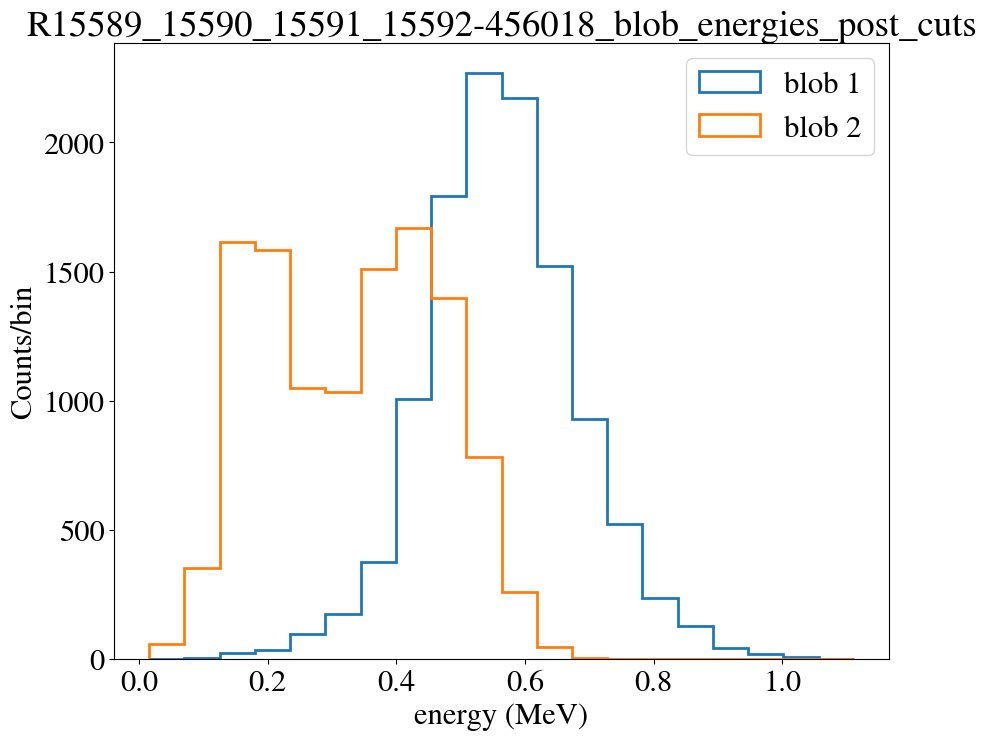

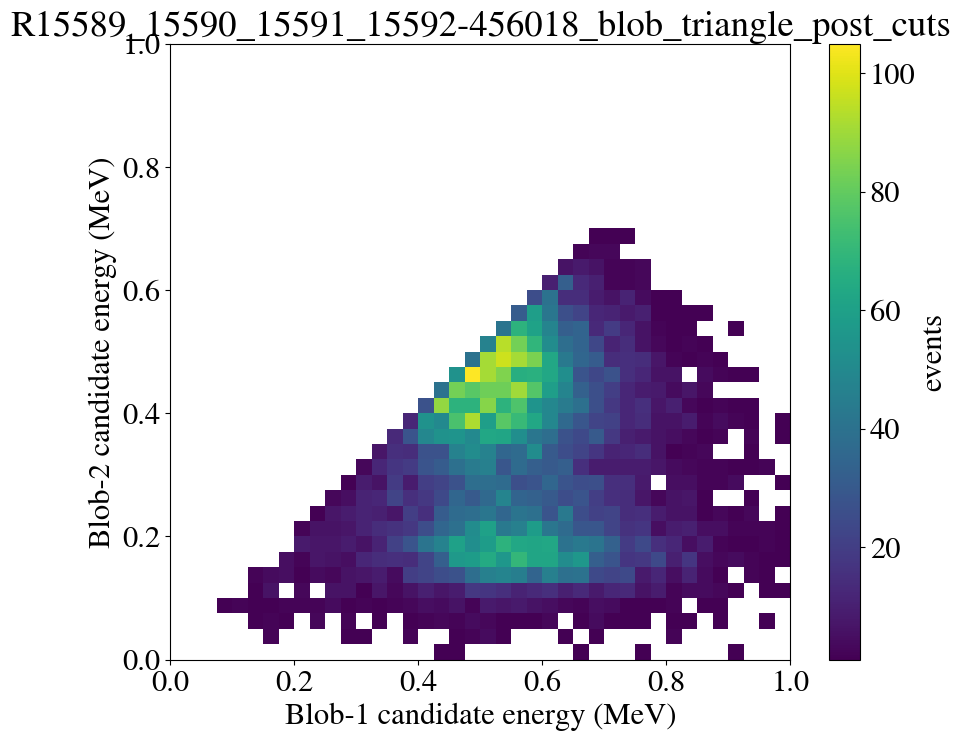

In [28]:
blob_title        = f'R{RUN_NUMBER}-{TIMESTAMP}_blob_energies_post_cuts'
blob_2dhits_title = f'R{RUN_NUMBER}-{TIMESTAMP}_blob_triangle_post_cuts'
# make range full range of blob1 and blob2
eblob_full = []
eblob_full.append(cut_hdst['eblob1'].to_numpy())
eblob_full.append(cut_hdst['eblob2'].to_numpy())

minimum_e = np.min(eblob_full)
maximum_e = np.max(eblob_full)

func.plot_hist(cut_hdst, column = 'eblob1', binning = 20, title = f'{blob_title}', output = False, fill = False, label = 'blob 1', x_label = 'energy (MeV)', range = (minimum_e, maximum_e), log = False)
func.plot_hist(cut_hdst, column = 'eblob2', binning = 20, title = f'{blob_title}', output = False, fill = False, label = 'blob 2', x_label = 'energy (MeV)', range = (minimum_e, maximum_e), log = False)
plt.savefig(f'{folder_name}blob/{blob_title}.png')
plt.legend()
plt.show()

# blob 2dhist
plt.hist2d(cut_hdst['eblob1'], cut_hdst['eblob2'], bins=(40, 40), range=((0, 1), (0, 1)), cmap='viridis', cmin=0.001)
plt.colorbar(label='events')
plt.xlabel("Blob-1 candidate energy (MeV)")
plt.ylabel("Blob-2 candidate energy (MeV)")
plt.title(f'{blob_2dhits_title}')
plt.savefig(f'{folder_name}blob/{blob_2dhits_title}.png')
plt.show()

# cut by cut plots

### fiducial track cut

In [132]:
fid_hdst = func.fiducial_track_cut_2( hdst
                                    , lower_z = low_z
                                    , upper_z = upp_z
                                    , r_lim   = r_lim)

_ = func.cut_effic(fid_hdst, hdst, verbose = True)

Efficiency: 21.43 %
Events in reduced dataframe: 70203
Events in initial dataframe: 539034


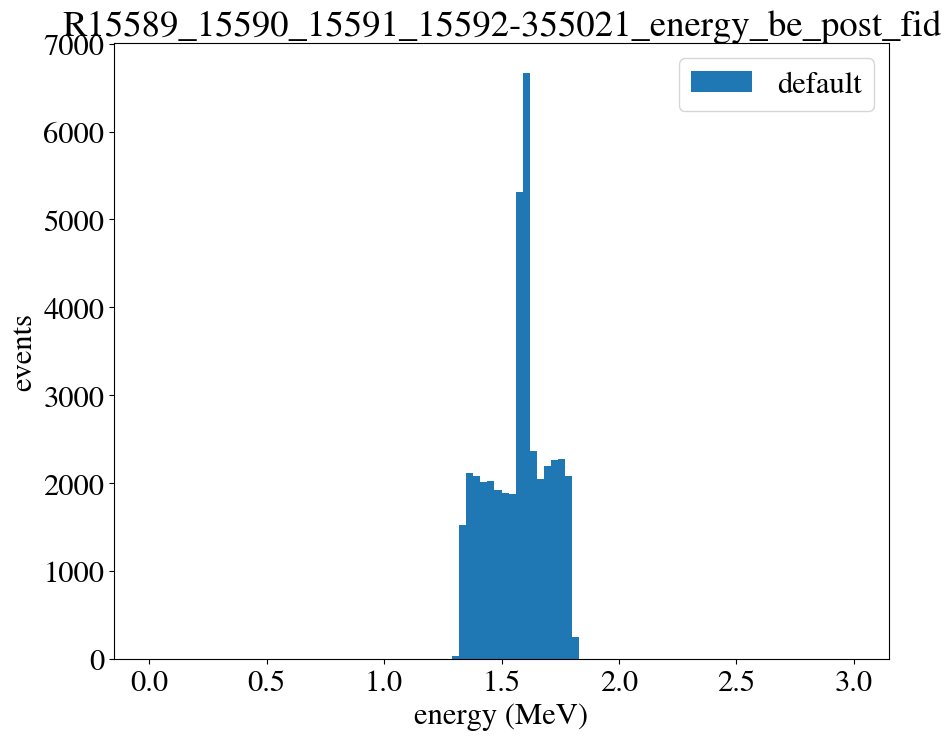

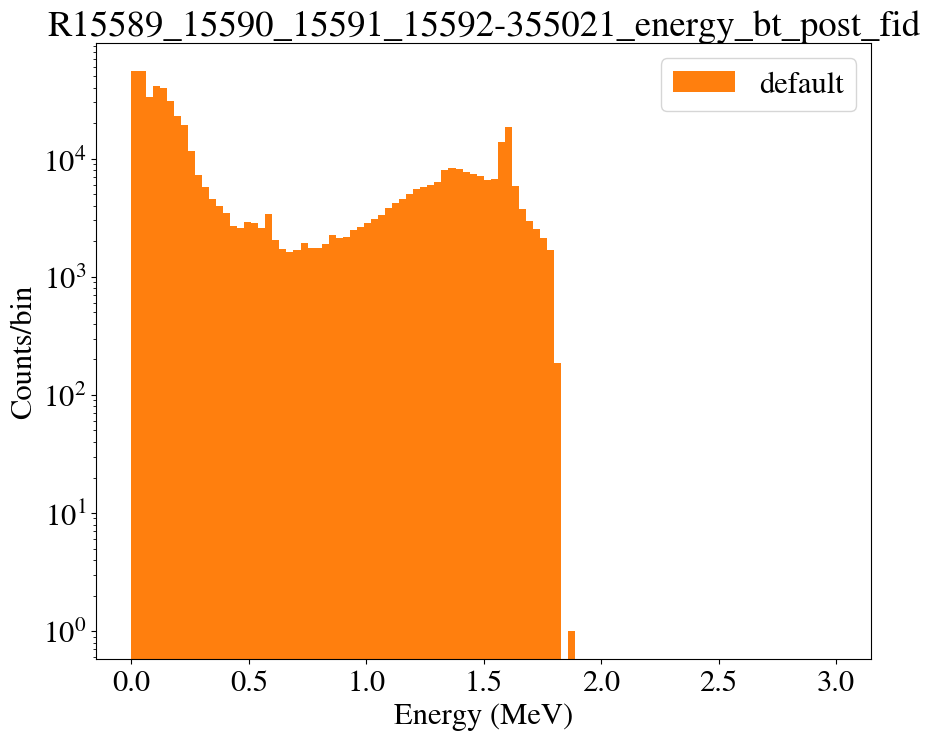

In [133]:
func.plot_hist_over_column(  fid_hdst
                           , 'event'
                           , 'energy'
                           , lambda x: x.sum()
                           , binning = 100
                           , range = (0, 3)
                           , log = False
                           , output = True
                           , title = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_be_post_fid'
                           , save = True
                           , save_dir = f'{folder_name}energy/')


func.plot_hist( hdst
              , 'energy'
              , binning = 100
              , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_bt_post_fid'
              , x_label = 'Energy (MeV)'
              , range   = (0, 3)
              , log     = True
              , output  = True
              , save = True
              , save_dir = f'{folder_name}energy/')


# One track cut

In [134]:
ot_hdst = func.one_track_cuts(fid_hdst)

_ = func.cut_effic(ot_hdst, fid_hdst, verbose = True)

Efficiency: 53.57 %
Events in reduced dataframe: 21948
Events in initial dataframe: 70203


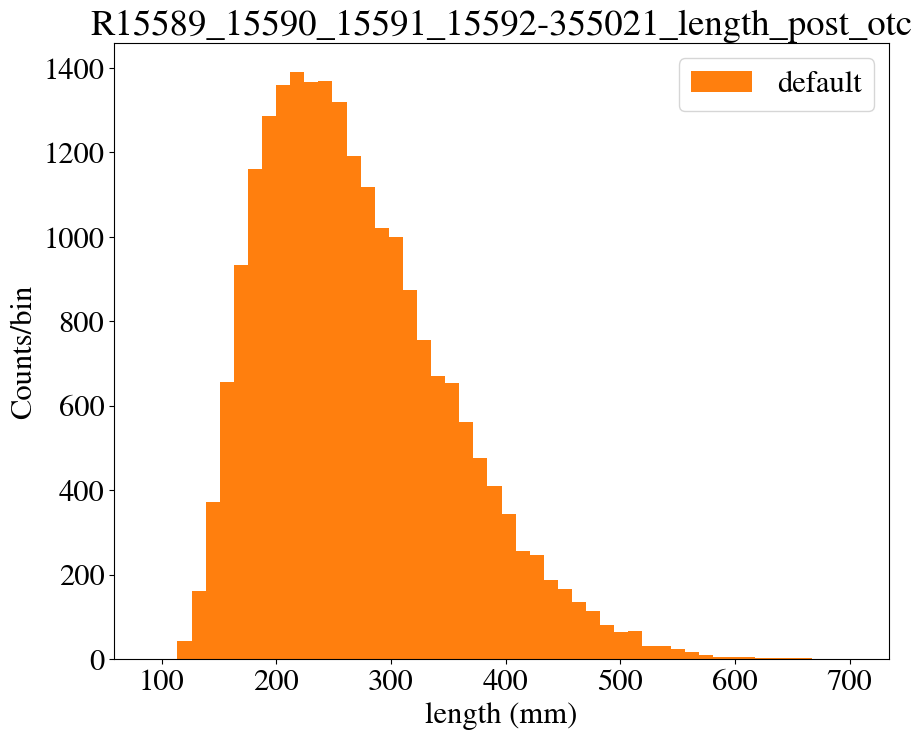

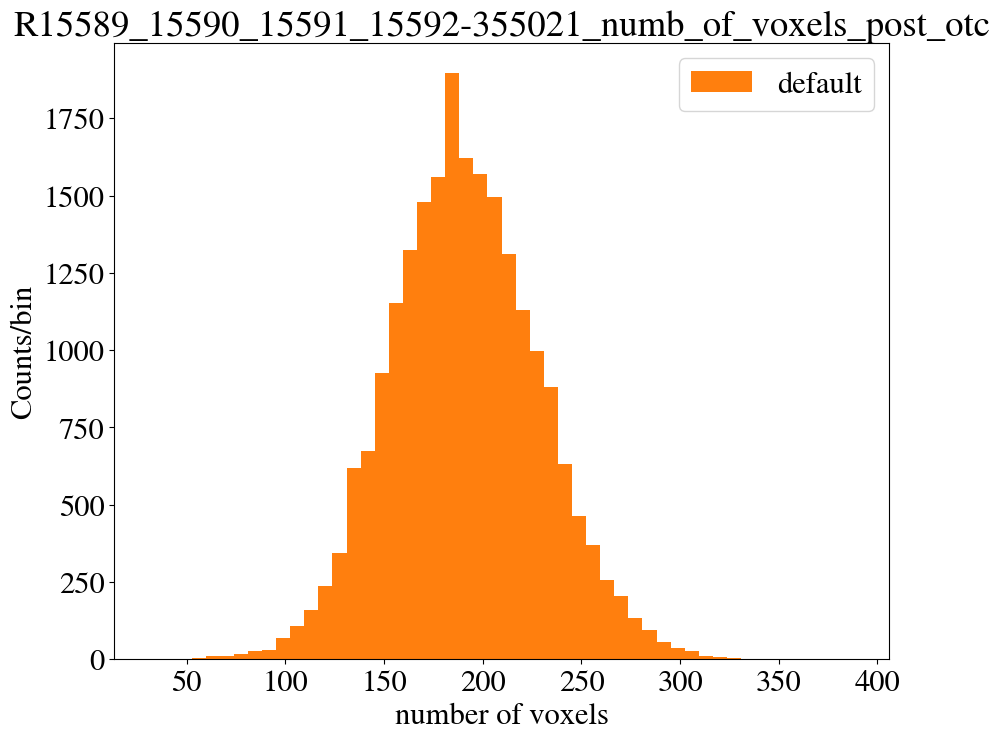

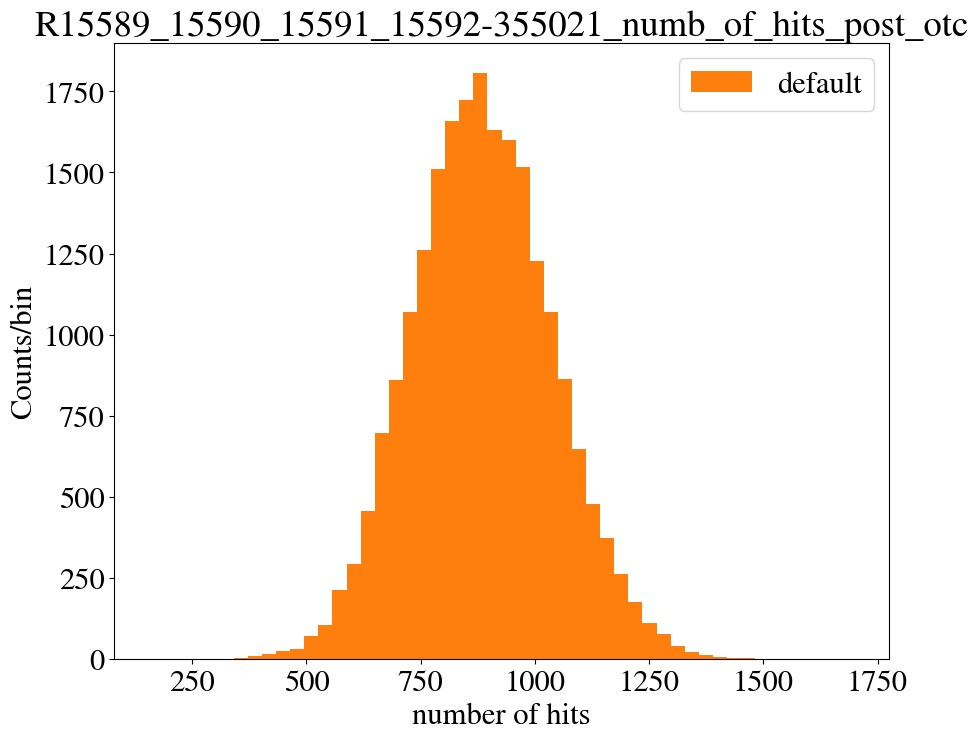

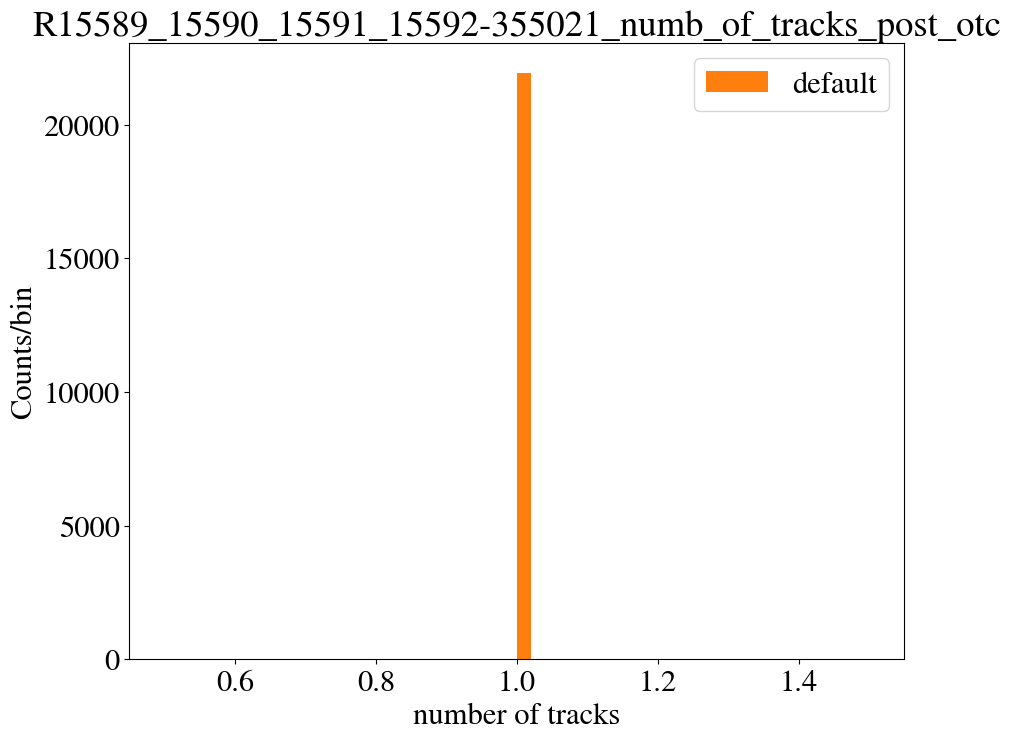

In [135]:
# plot track related shenanigans
for vars, labels in zip(top_vars, top_labels):
    func.plot_hist( ot_hdst
                  , vars
                  , binning  = 50
                  , title    = f'R{RUN_NUMBER}-{TIMESTAMP}_{vars}_post_otc'
                  , x_label  = f'{labels}'
                  , outliers = (0, 99.99999)
                  , log      = log_flag
                  , output   = True
                  , save     = True
                  , save_dir = f'{folder_name}topology/')

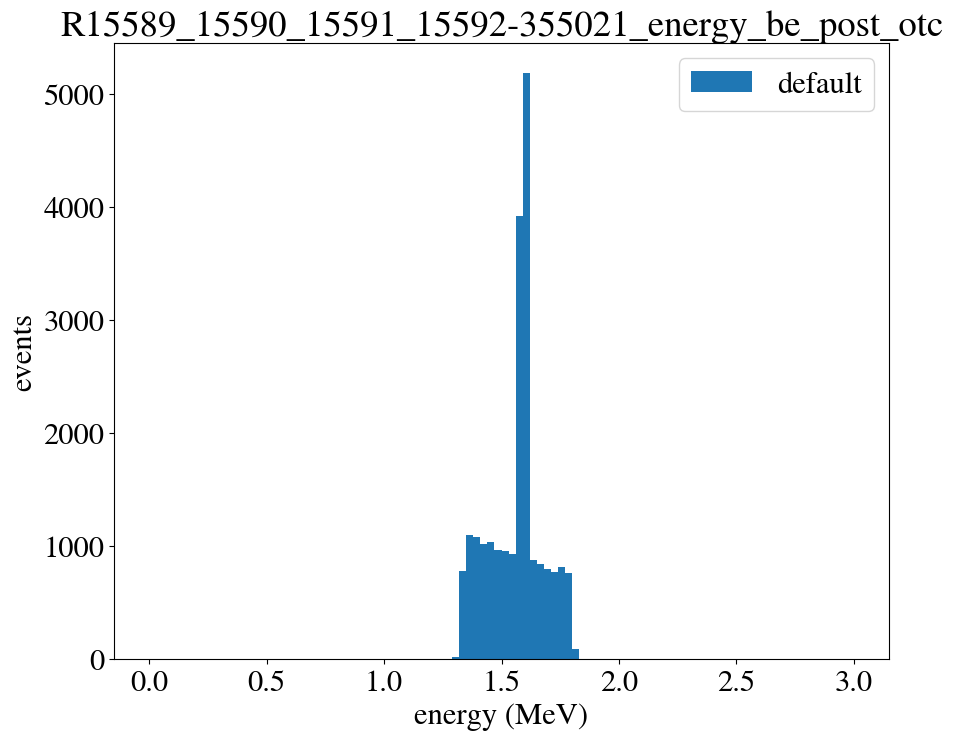

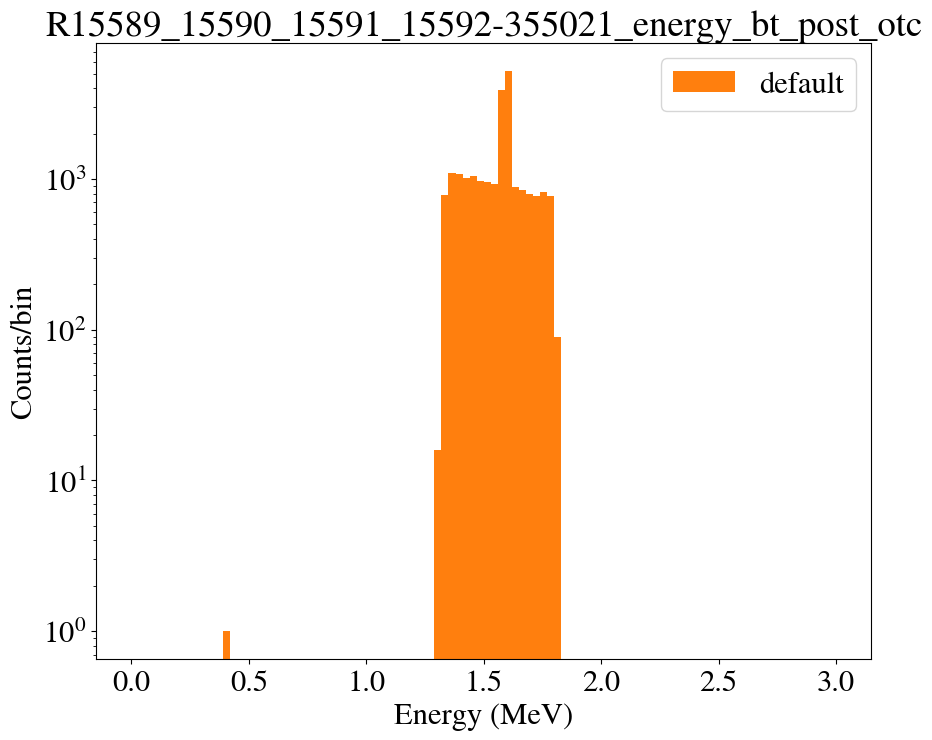

In [136]:
func.plot_hist_over_column(  ot_hdst
                           , 'event'
                           , 'energy'
                           , lambda x: x.sum()
                           , binning = 100
                           , range = (0, 3)
                           , log = False
                           , output = True
                           , title = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_be_post_otc'
                           , save = True
                           , save_dir = f'{folder_name}energy/')


func.plot_hist( ot_hdst
              , 'energy'
              , binning = 100
              , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_bt_post_otc'
              , x_label = 'Energy (MeV)'
              , range   = (0, 3)
              , log     = True
              , output  = True
              , save = True
              , save_dir = f'{folder_name}energy/')


# overlap cut

In [137]:
ovlp_hdst = func.overlapping_cuts(ot_hdst)

_ = func.cut_effic(ovlp_hdst, ot_hdst, verbose = True)

Efficiency: 97.07 %
Events in reduced dataframe: 21306
Events in initial dataframe: 21948


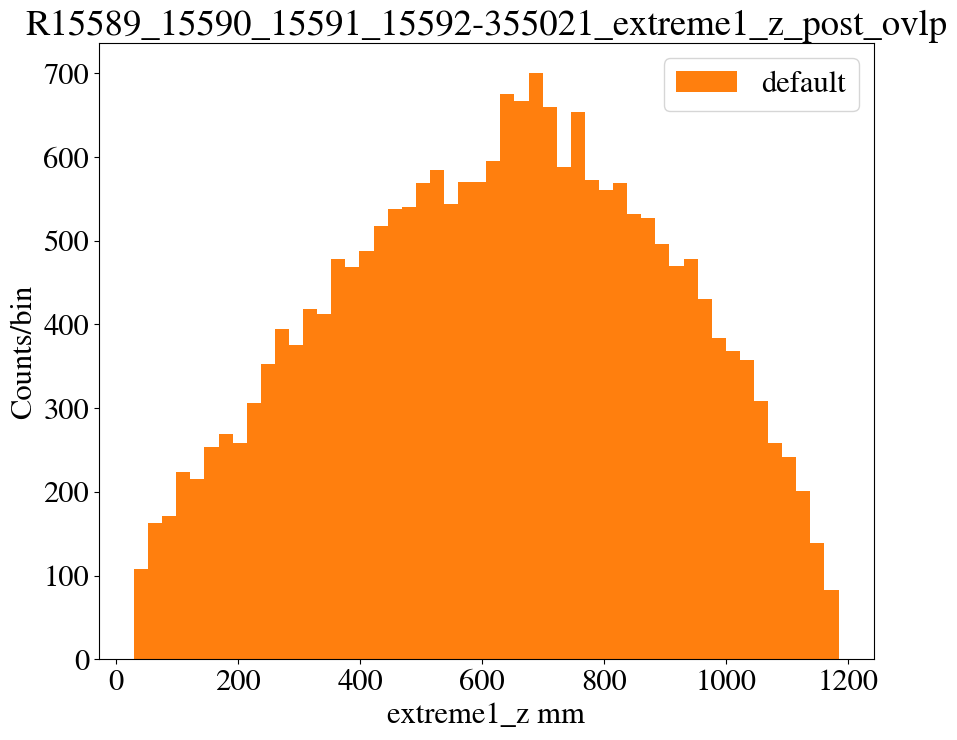

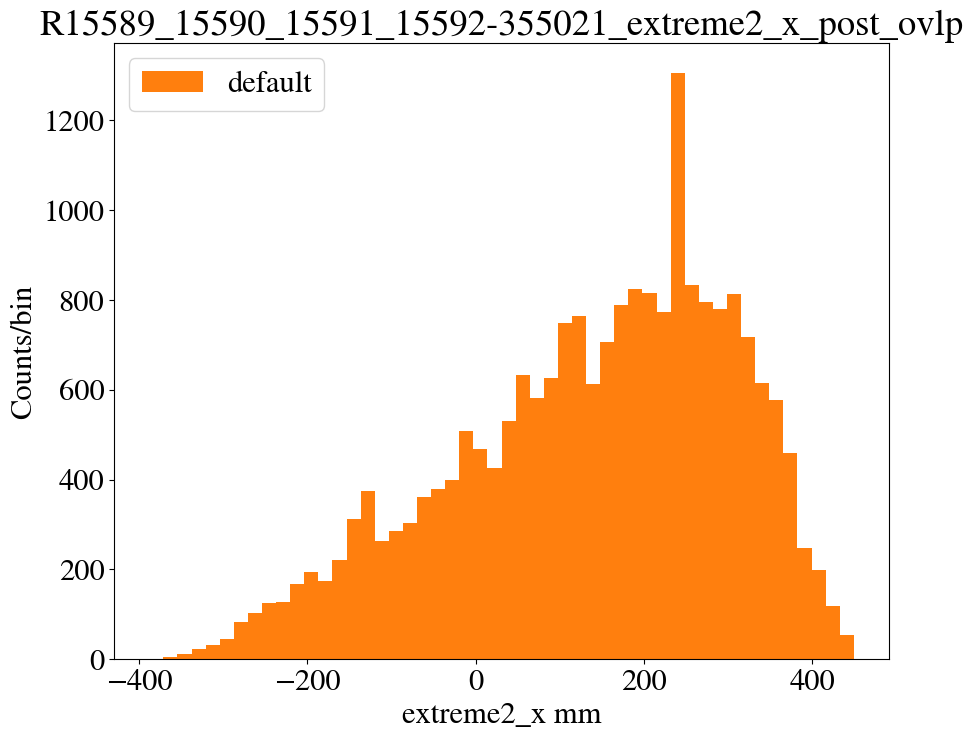

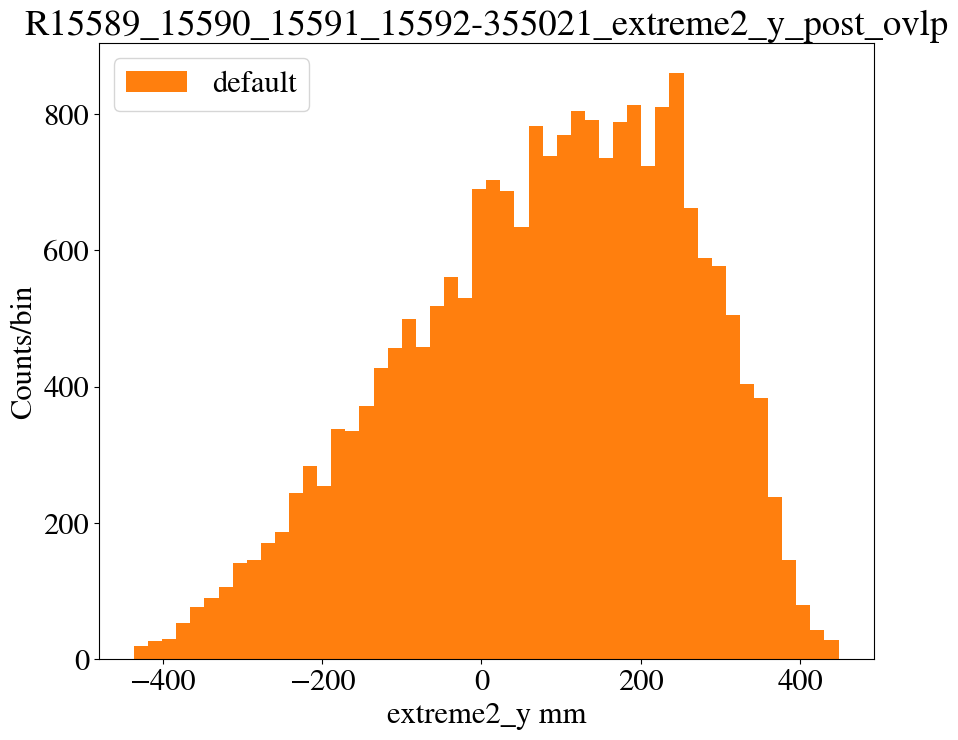

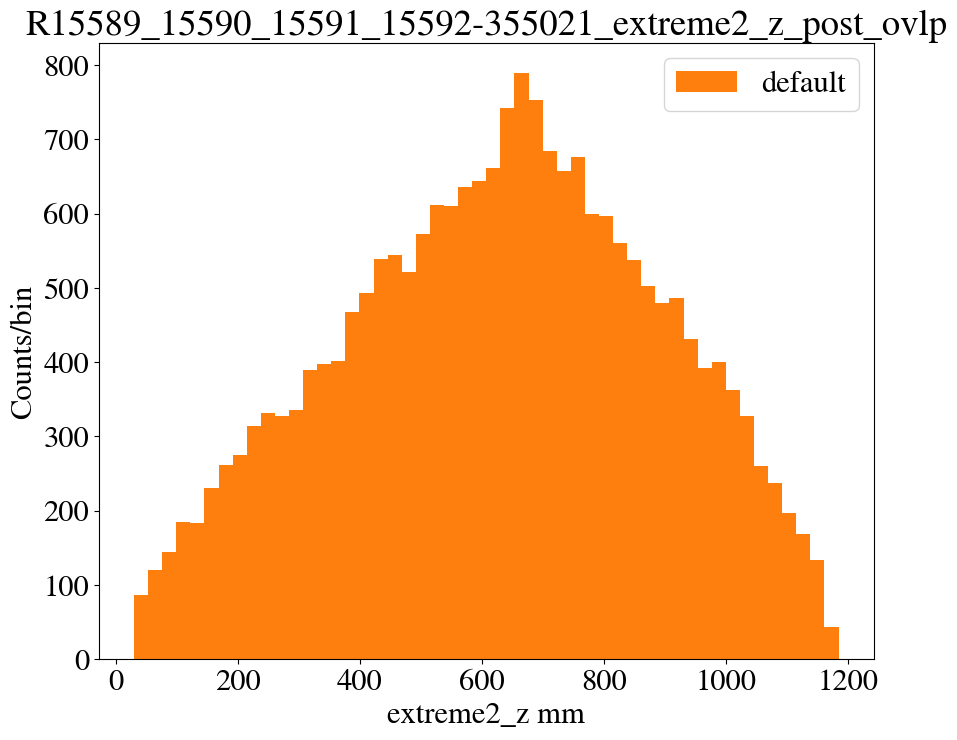

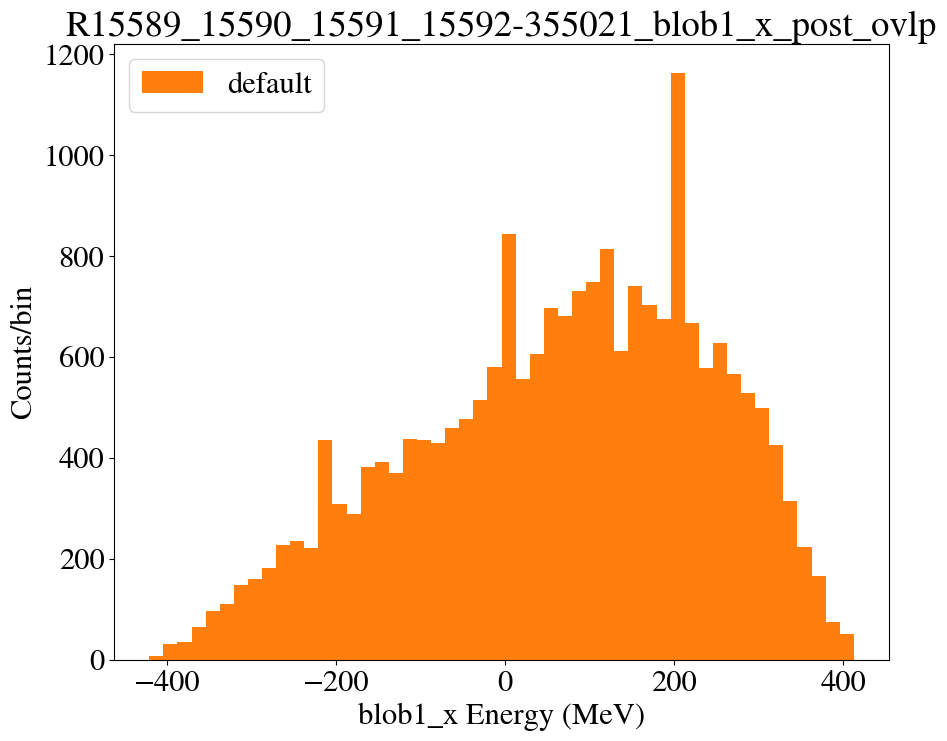

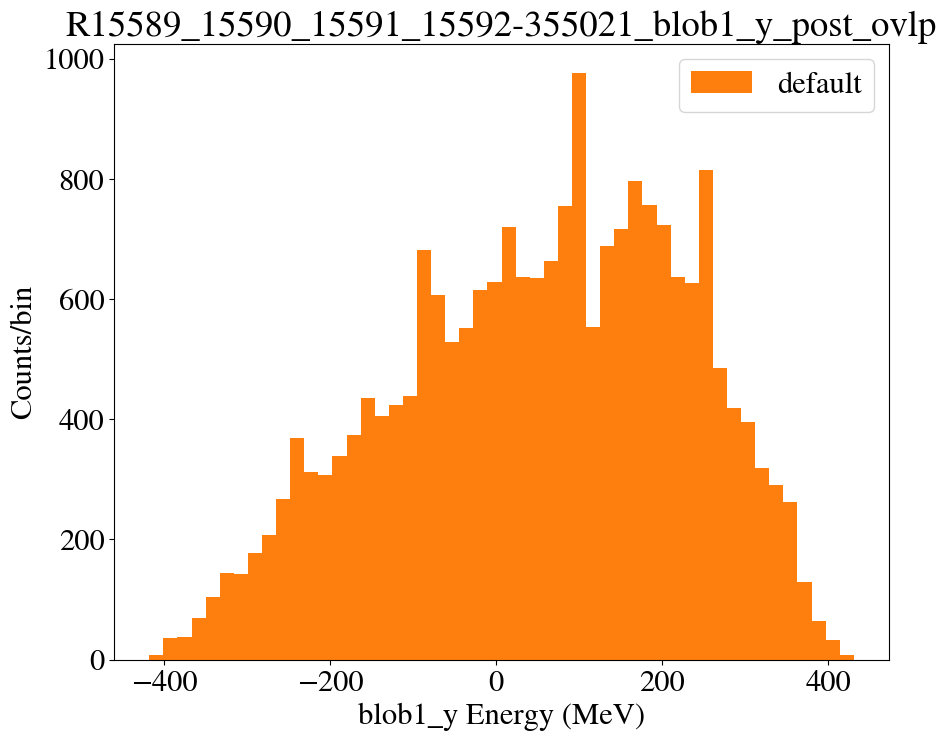

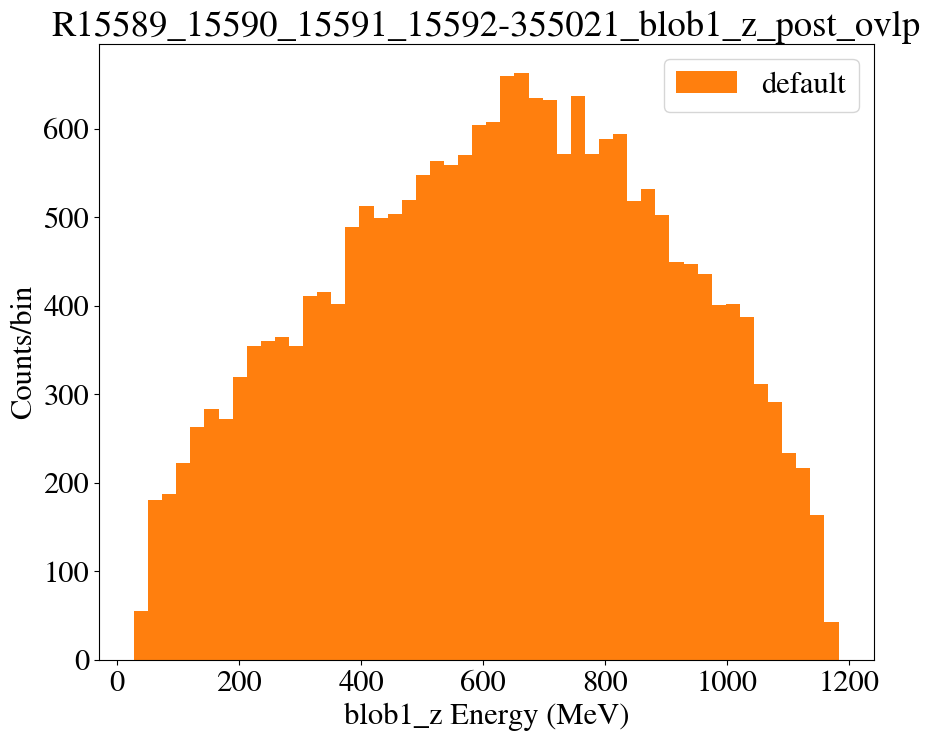

In [138]:
for vars, labels in zip(blob_vars, blob_labels):
    func.plot_hist( ovlp_hdst
                  , vars
                  , binning = 50
                  , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_{vars}_post_ovlp'
                  , x_label = f'{vars} {labels}'
                  #, outliers   = (0, 99.99999)
                  , log     = log_flag
                  , output  = True
                  , save = True
                  , save_dir = f'{folder_name}blob/')

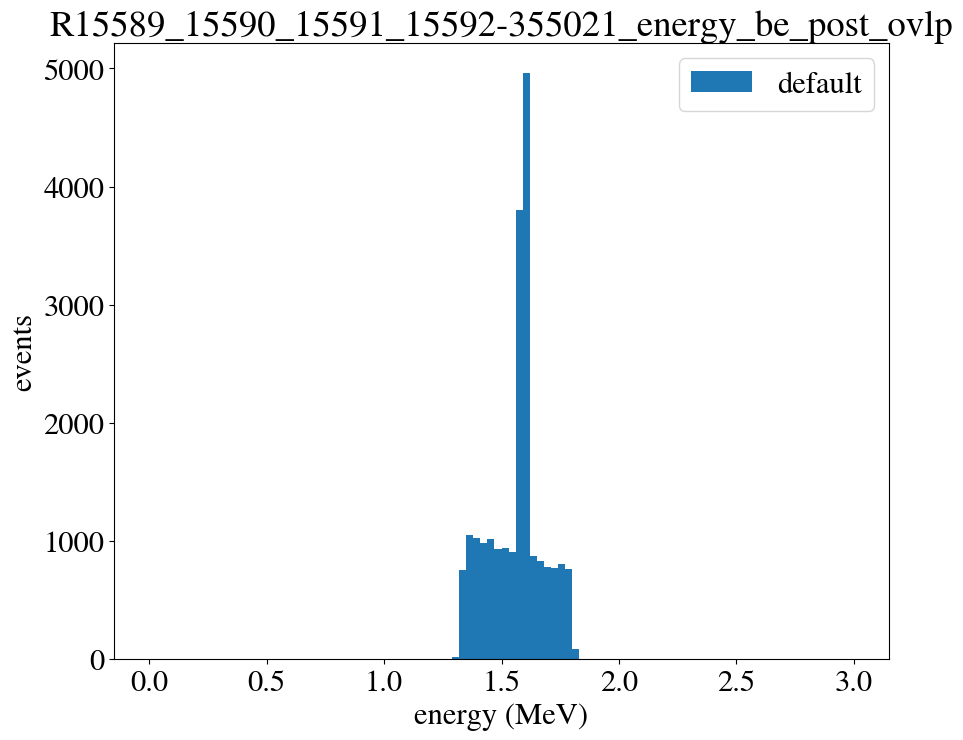

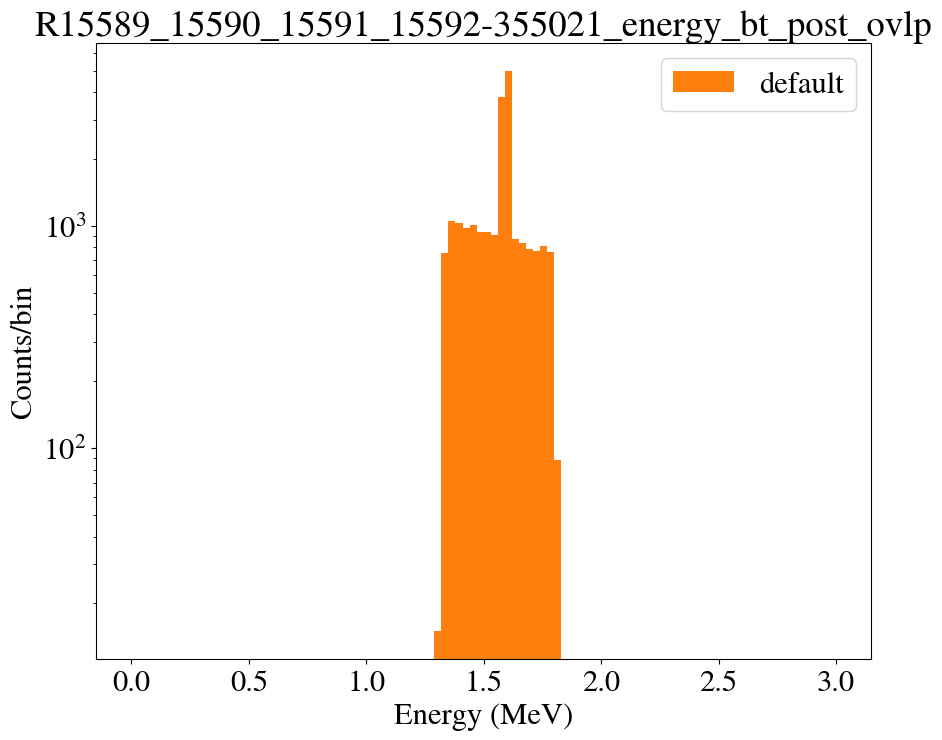

In [139]:
func.plot_hist_over_column(  ovlp_hdst
                           , 'event'
                           , 'energy'
                           , lambda x: x.sum()
                           , binning = 100
                           , range = (0, 3)
                           , log = False
                           , output = True
                           , title = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_be_post_ovlp'
                           , save = True
                           , save_dir = f'{folder_name}energy/')


func.plot_hist( ovlp_hdst
              , 'energy'
              , binning = 100
              , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_bt_post_ovlp'
              , x_label = 'Energy (MeV)'
              , range   = (0, 3)
              , log     = True
              , output  = True
              , save = True
              , save_dir = f'{folder_name}energy/')


# energy cut

In [140]:
e_hdst = func.energy_cuts(ovlp_hdst
                         , lower_e = low_e
                         , upper_e = upp_e)

_ = func.cut_effic(e_hdst, ovlp_hdst, verbose = True)

Efficiency: 60.18 %
Events in reduced dataframe: 12823
Events in initial dataframe: 21306


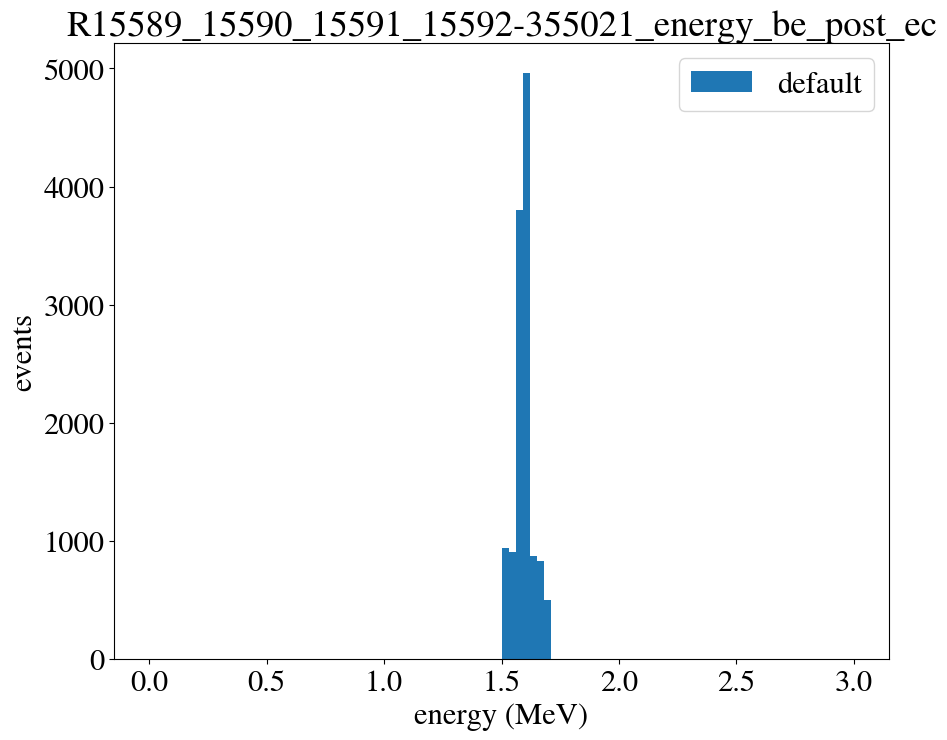

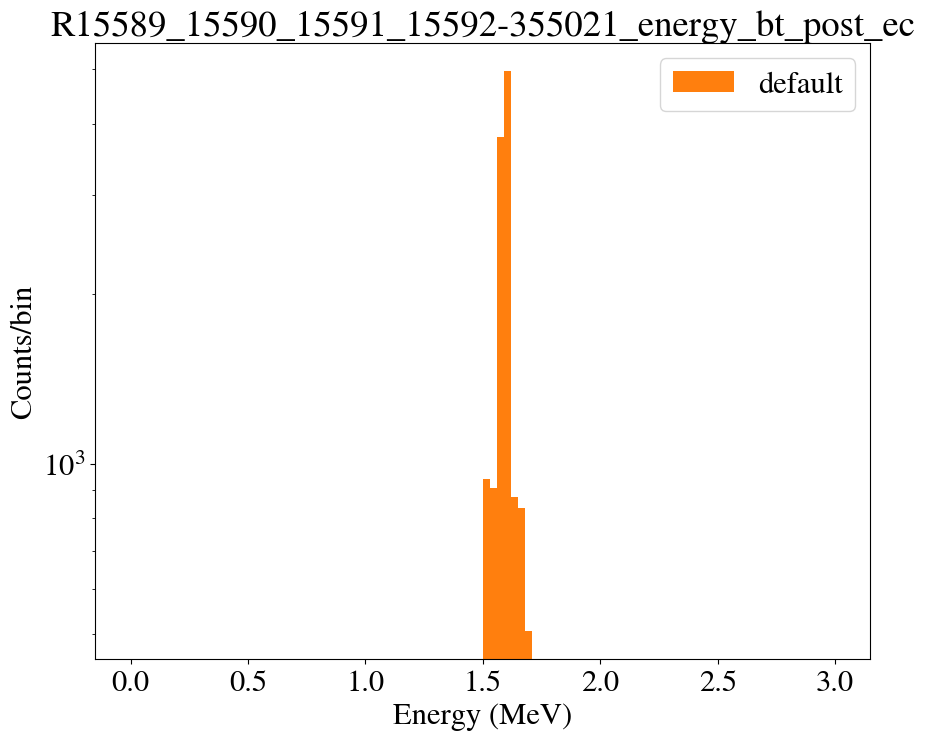

In [141]:
func.plot_hist_over_column(  e_hdst
                           , 'event'
                           , 'energy'
                           , lambda x: x.sum()
                           , binning = 100
                           , range = (0, 3)
                           , log = False
                           , output = True
                           , title = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_be_post_ec'
                           , save = True
                           , save_dir = f'{folder_name}energy/')


func.plot_hist( e_hdst
              , 'energy'
              , binning = 100
              , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_bt_post_ec'
              , x_label = 'Energy (MeV)'
              , range   = (0, 3)
              , log     = True
              , output  = True
              , save = True
              , save_dir = f'{folder_name}energy/')


# Now plot the energy histograms atop each other

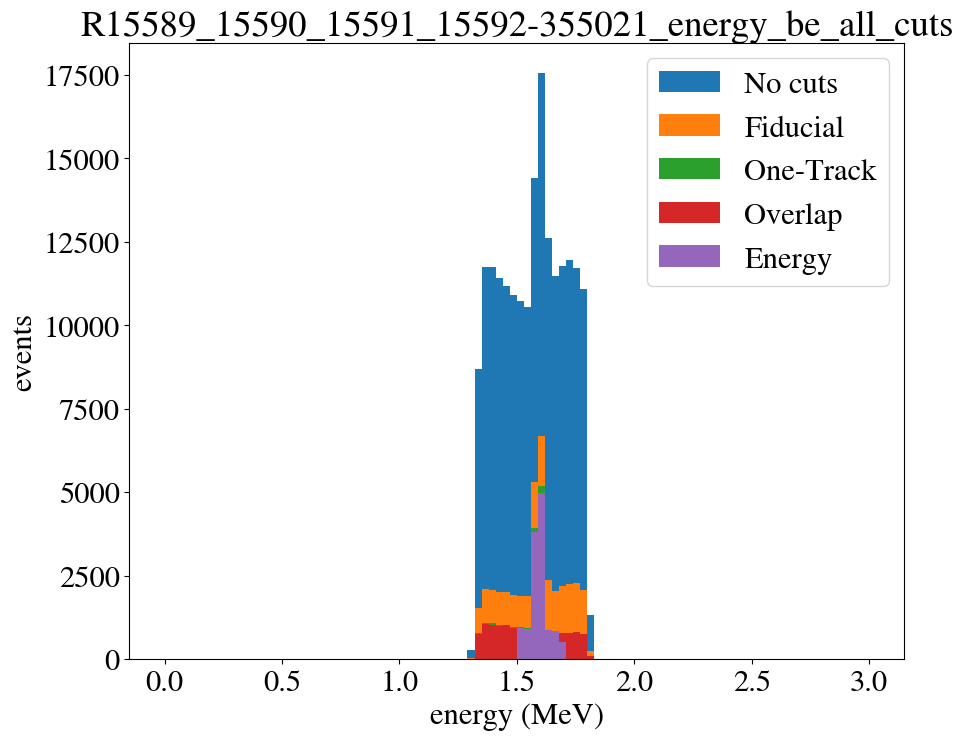

In [142]:
func.plot_hist_over_column(  hdst
                           , 'event'
                           , 'energy'
                           , lambda x: x.sum()
                           , binning = 100
                           , range = (0, 3)
                           , log = False
                           , label = f'No cuts'
                           , title = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_be')

func.plot_hist_over_column(  fid_hdst
                           , 'event'
                           , 'energy'
                           , lambda x: x.sum()
                           , binning = 100
                           , range = (0, 3)
                           , label = f'Fiducial'
                           , log = False
                           , title = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_be')

func.plot_hist_over_column(  ot_hdst
                           , 'event'
                           , 'energy'
                           , lambda x: x.sum()
                           , binning = 100
                           , range = (0, 3)
                           , label = f'One-Track'
                           , log = False
                           , title = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_be')

func.plot_hist_over_column(  ovlp_hdst
                           , 'event'
                           , 'energy'
                           , lambda x: x.sum()
                           , binning = 100
                           , range = (0, 3)
                           , label = f'Overlap'
                           , log = False
                           , title = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_be')

func.plot_hist_over_column(  e_hdst
                           , 'event'
                           , 'energy'
                           , lambda x: x.sum()
                           , binning = 100
                           , range = (0, 3)
                           , label = f'Energy'
                           , log = False
                           , output = True
                           , title = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_be_all_cuts'
                           , save = True
                           , save_dir = f'{folder_name}energy/')

In [143]:
func.plot_hist_over_column(  hdst
                           , 'event'
                           , 'energy'
                           , lambda x: x.sum()
                           , binning = 100
                           , range = (0, 3)
                           , log = True
                           , label = f'No cuts'
                           , title = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_be')

func.plot_hist_over_column(  fid_hdst
                           , 'event'
                           , 'energy'
                           , lambda x: x.sum()
                           , binning = 100
                           , range = (0, 3)
                           , label = f'Fiducial'
                           , log = True
                           , title = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_be')

func.plot_hist_over_column(  ot_hdst
                           , 'event'
                           , 'energy'
                           , lambda x: x.sum()
                           , binning = 100
                           , range = (0, 3)
                           , label = f'One-Track'
                           , log = True
                           , title = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_be')

func.plot_hist_over_column(  ovlp_hdst
                           , 'event'
                           , 'energy'
                           , lambda x: x.sum()
                           , binning = 100
                           , range = (0, 3)
                           , label = f'Overlap'
                           , log = True
                           , title = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_be')

func.plot_hist_over_column(  e_hdst
                           , 'event'
                           , 'energy'
                           , lambda x: x.sum()
                           , binning = 100
                           , range = (0, 3)
                           , label = f'Energy'
                           , log = True
                           , output = True
                           , title = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_be_all_cuts_log'
                           , save = True
                           , save_dir = f'{folder_name}energy/')

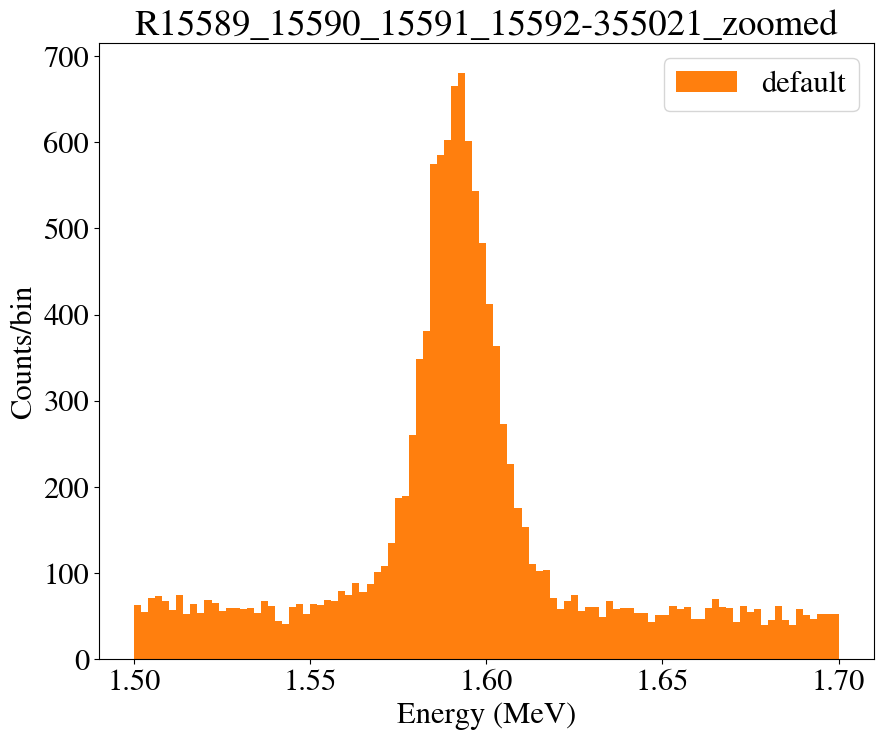

In [144]:
func.plot_hist( e_hdst
              , 'energy'
              , binning = 100
              , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_zoomed'
              , x_label = 'Energy (MeV)'
              , range   = (1.5, 1.7)
              , log     = False
              , output  = True
              , save = True
              , save_dir = f'{folder_name}energy/')

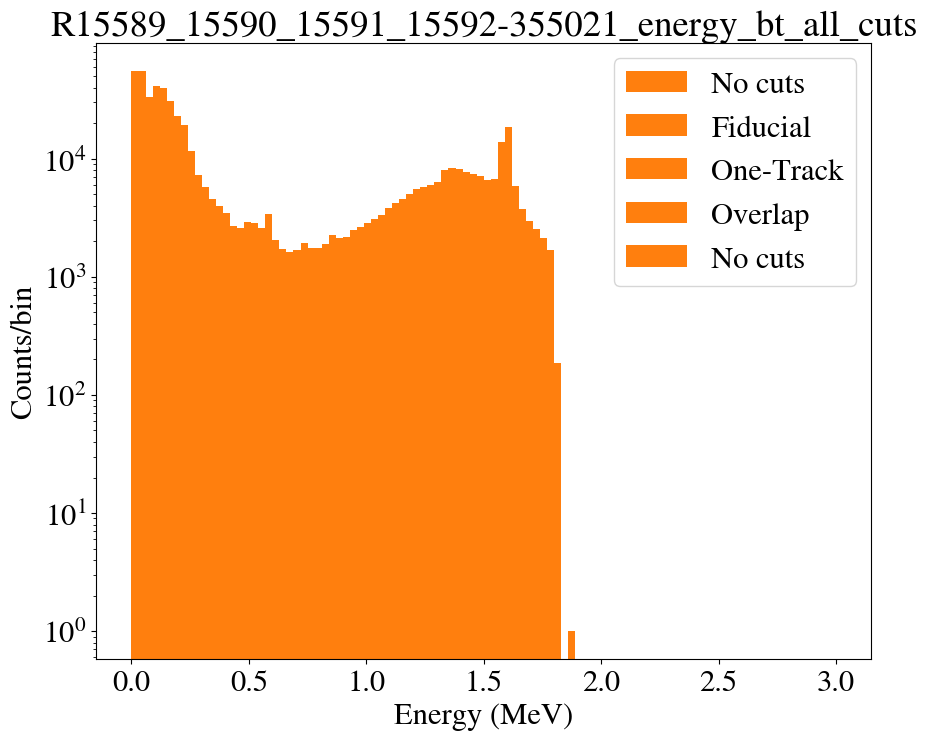

In [145]:
func.plot_hist( hdst
              , 'energy'
              , binning = 100
              , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_bt_all_cuts'
              , x_label = 'Energy (MeV)'
              , range   = (0, 3)
              , log     = True
              , label   = f'No cuts')

func.plot_hist( fid_hdst
              , 'energy'
              , binning = 100
              , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_bt_all_cuts'
              , x_label = 'Energy (MeV)'
              , range   = (0, 3)
              , log     = True
              , label   = f'Fiducial')

func.plot_hist( ot_hdst
              , 'energy'
              , binning = 100
              , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_bt_all_cuts'
              , x_label = 'Energy (MeV)'
              , range   = (0, 3)
              , log     = True
              , label   = f'One-Track')


func.plot_hist( ovlp_hdst
              , 'energy'
              , binning = 100
              , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_bt_all_cuts'
              , x_label = 'Energy (MeV)'
              , range   = (0, 3)
              , log     = True
              , label   = f'Overlap')


func.plot_hist( e_hdst
              , 'energy'
              , binning = 100
              , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_bt_all_cuts'
              , x_label = 'Energy (MeV)'
              , range   = (0, 3)
              , log     = True
              , label   = f'No cuts'
              , output = True
              , save = True
              , save_dir = f'{folder_name}energy/')